# Mask R-CNN - Train on OCR Dataset


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.patches as patches

from config import Config
import utils
import model as modellib
import visualize
from model import log

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 


# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_ocr_0002.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "data/image")

/home/nghia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
import ocr
    
config = ocr.OcrConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           ocr
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING       

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
# Training dataset
dataset_train = ocr.OcrDataset()
dataset_train.load_ocr(np.load('ocr-train-cv.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = ocr.OcrDataset()
dataset_val.load_ocr(np.load('ocr-val.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

(165,)
(1024, 1024, 165)


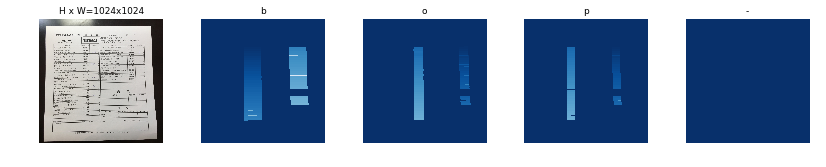

(165,)
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(1024, 1024, 165)


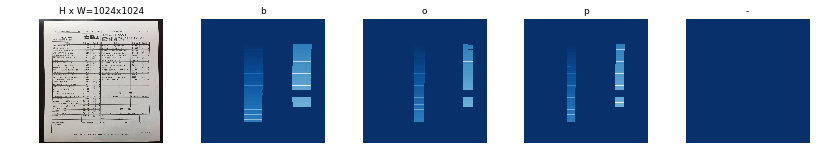

In [5]:
# Load and display random samples
plt.figure(figsize=(18, 18))
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids.shape)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids.shape)
    print(class_ids)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model


In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [18]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
    print (model.find_last()[1])

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")
print (dataset_val)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [6]:
# class InferenceConfig(ocr.Config()):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()
config.GPU_COUNT =1
config.IMAGES_PER_GPU =1
config.BATCH_SIZE = 1
    
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_ocr_0002.h5")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/nghia/work/Mask_RCNN/logs/ocr20180328T1404/mask_rcnn_ocr_0002.h5


original_image           shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000
image_meta               shape: (12,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (165,)                min:    1.00000  max:    3.00000
gt_bbox                  shape: (165, 4)              min:  205.00000  max:  884.00000
gt_mask                  shape: (1024, 1024, 165)     min:    0.00000  max:    1.00000


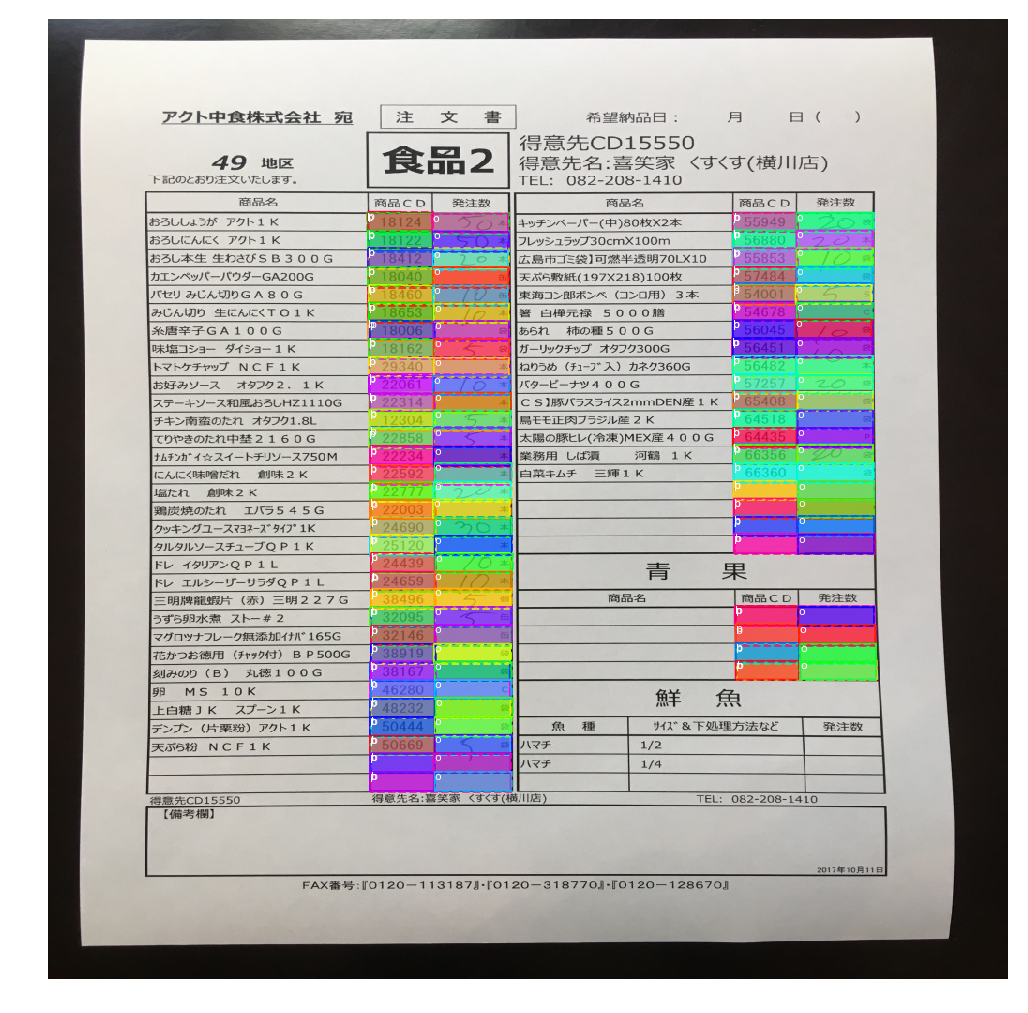

In [7]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 3
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask = False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
# print (gt_mask)
# nx,ny,nz=np.shape(gt_mask)
# CXY=np.zeros([ny, nx])
# for i in range(ny):
#     for j in range(nx):
#         CXY[i,j]=np.max(gt_mask[j,i,:])
        
# u, indices = np.unique(gt_mask, return_index=True)
# print(u)

# #Binary data
# np.save('maximums.txt', CXY)
# data = np.load('maximums.npy')
# print ("DATA:", data)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(18, 18))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -115.70000  max:  151.10000
image_metas              shape: (1, 12)               min:    0.00000  max: 1024.00000
(1024, 1024, 100)
(1024, 1024)


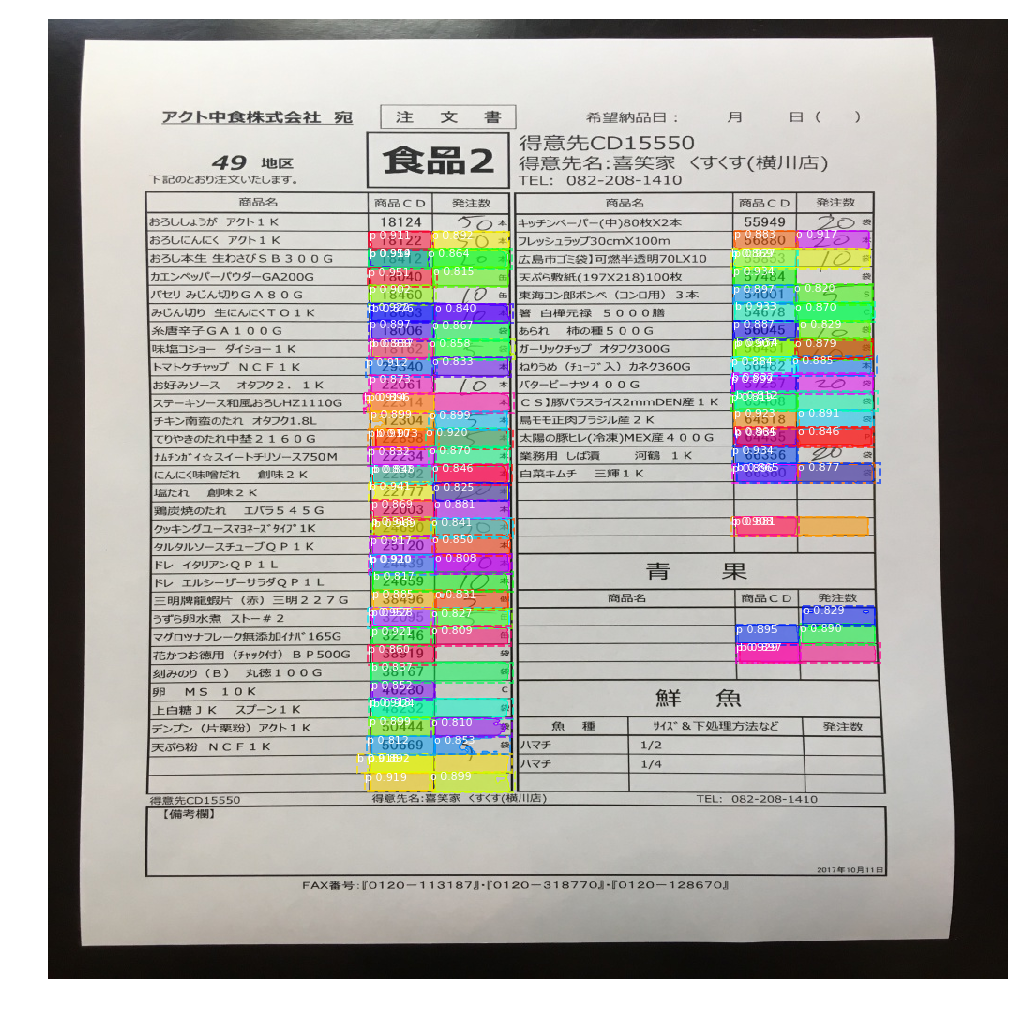

In [84]:
# import matplotlib
# import matplotlib.pyplot as plt
# plt.figure(figsize=(25, 20))
results = model.detect([original_image], verbose=1)

r = results[0]
# r = results
# print(r)
# print (results)
# print( r['rois'])
# print("Mask: ", r['masks'])
print(r['masks'].shape)
print(r['masks'][:,:,0].shape)
# plt.imshow( r['masks'][:,:,0])
# plt.show()
# cv2.imwrite('mask.jpg', r['masks'][:,:,0])
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(20, 18))


In [81]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon

print(r['masks'].shape)
print(r['masks'][:,:,0].shape)

masks = r['masks']
classes = r['class_ids']
print(classes.shape)

i = 70
mask = masks[:, :, i]
# masked_image = apply_mask(masked_image, mask, color)

# Mask Polygon
# Pad to ensure proper polygons for masks that touch image edges.
padded_mask = np.zeros(
    (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
padded_mask[1:-1, 1:-1] = mask
contours = find_contours(padded_mask, 0.5)
# print(np.array(contours).shape)

# figsize = (18, 18)
# _, ax = plt.subplots(1, figsize=figsize)
# height, width = mask.shape[:2]
# ax.set_ylim(height - 200, 500)
# ax.set_xlim(400, width + 10)
# # ax.axis('off')
# # ax.set_title(title)

# for verts in contours:
# #     print(verts)
#     # Subtract the padding and flip (y, x) to (x, y)
#     verts = np.fliplr(verts) - 1
#     p = Polygon(verts, facecolor="none", edgecolor='red')
#     ax.add_patch(p)

# plt.show()

(1024, 1024, 100)
(1024, 1024)
(100,)


(1026, 1026)
(1, 205, 2)
(205, 2)
(5, 2)
[[265.5 489. ]
 [264.5 413. ]
 [248.  411.5]
 [245.5 487. ]
 [265.5 489. ]]
(1, 5, 2)
[[265.5 489. ]
 [264.5 413. ]
 [248.  411.5]
 [245.5 487. ]
 [265.5 489. ]]


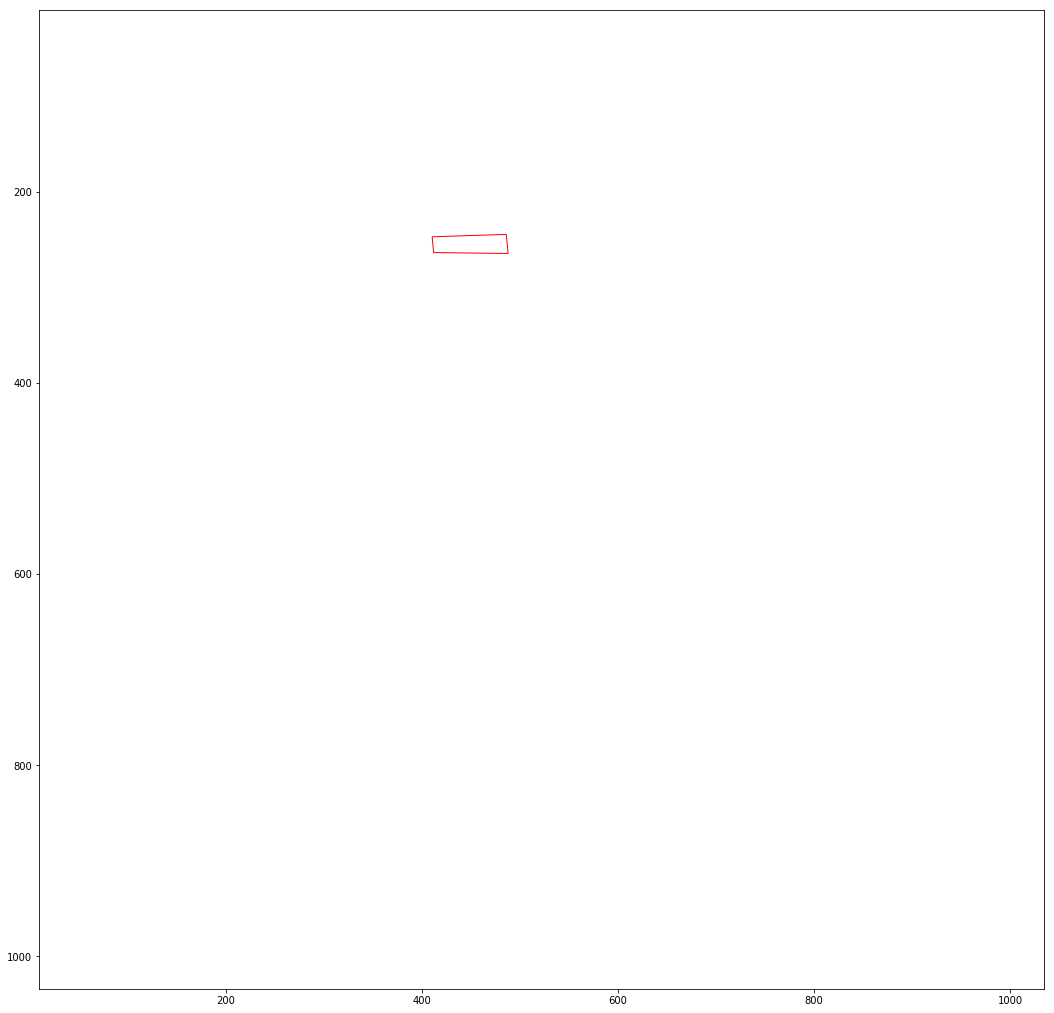

In [82]:
from skimage.measure import subdivide_polygon, approximate_polygon

print(padded_mask.shape)

contours = np.array(contours)
print(contours.shape)
print(contours.reshape(-1, 2).shape)
contours_sub = approximate_polygon(contours.reshape(-1, 2), 10)
print(contours_sub.shape)
print(contours_sub)
contours_sub1 = np.expand_dims(contours_sub, axis=0)
print(contours_sub1.shape)

figsize = (18, 18)
_, ax = plt.subplots(1, figsize=figsize)
height, width = mask.shape[:2]
ax.set_ylim(height + 10, 10)
ax.set_xlim(10, width + 10)
# ax.axis('off')
# ax.set_title(title)

for verts in contours_sub1:
    # Subtract the padding and flip (y, x) to (x, y)
    print(verts)
#     verts = list(map(int, verts))
#     print(verts)
    verts = np.fliplr(verts) - 1
    p = Polygon(verts, facecolor="none", edgecolor='red')
    ax.add_patch(p)

plt.show()

[[343 491]
 [344 415]
 [360 414]
 [361 491]]


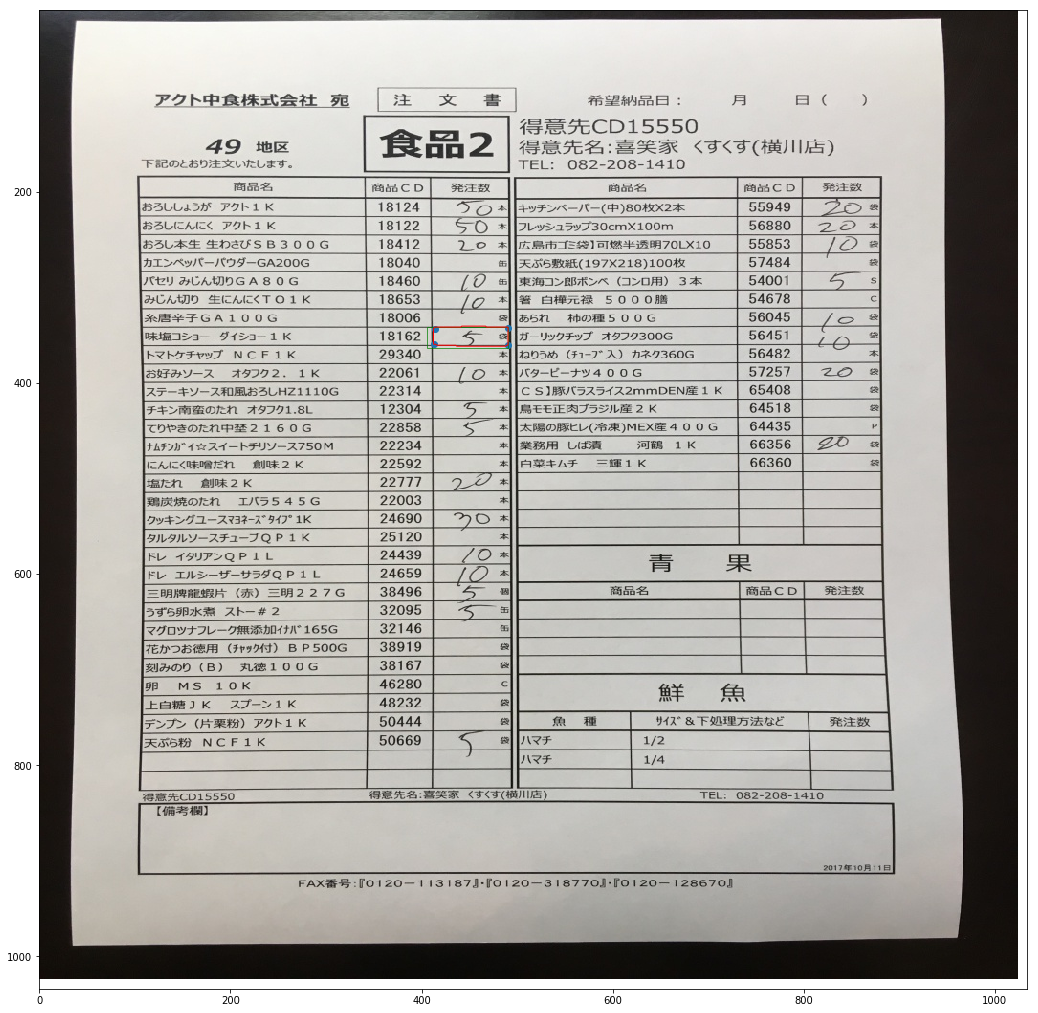

In [157]:
from skimage.feature import corner_harris, corner_peaks
import matplotlib.patches

boxes = r['rois']

i = 72
mask = masks[:, :, i]
# masked_image = apply_mask(masked_image, mask, color)

# Mask Polygon
# Pad to ensure proper polygons for masks that touch image edges.
padded_mask = np.zeros(
    (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
padded_mask[1:-1, 1:-1] = mask
contours = find_contours(padded_mask, 0.5)

verts1 = corner_peaks(corner_harris(padded_mask), min_distance=5)
print(verts1)

figsize = (22, 18)
_, ax = plt.subplots(1, figsize=figsize)
height, width = mask.shape[:2]
# ax.set_ylim(height - 700, 200)
# ax.set_xlim(400, width - 500)
ax.set_ylim(height + 10, 10)
ax.set_xlim(0, width + 10)
# ax.axis('off')
# ax.set_title(title)

masked_image = original_image.copy()

y1, x1, y2, x2 = boxes[i]
p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1,
                      alpha=0.7, linestyle="solid",
                      edgecolor='green', facecolor='none')
ax.add_patch(p)

for verts in contours:
    # Subtract the padding and flip (y, x) to (x, y)
#     print(verts)
#     verts = list(map(int, verts))
#     print(verts)
    verts = np.fliplr(verts) - 1
    p = Polygon(verts, facecolor="none", edgecolor='red')
    ax.add_patch(p)
    verts1 = np.fliplr(verts1) - 1
#     p1 = Polygon(verts1, facecolor="none", edgecolor='blue')
#     ax.add_patch(p1)
#     print(verts1[0])
    x, y = verts1.T
    
    ax.scatter(x, y)
    
ax.imshow(masked_image.astype(np.uint8))
plt.show()

In [160]:
# import the necessary packages
import numpy as np
import cv2

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
#     print("four_point_transform rect", rect)

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped
# cv2.waitKey(0)

In [191]:
def predict_mask(original_image, mask, box):
    y1, x1, y2, x2 = box

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
#     print("box", box)
#     print("original_image", original_image.shape)
#     print("mask", mask.shape)
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
#     print("padded_mask", padded_mask.shape)
#     plt.imshow(padded_mask)
#     plt.show()
    verts1 = corner_peaks(corner_harris(padded_mask), min_distance=1)
#     print("corner_harris", verts1.shape)
#     print(verts1)
#     verts1 = np.append(verts1, [[y1-5, x1-5], [y2+5, x2+5]], axis=0)
#     print(verts1)
#     verts1.stack((np.array(y1, x1), np.array(y2, x2)))
    verts1 = np.fliplr(verts1) - 1
#     print(verts1.shape)
    crop_img = original_image.copy()
    
#     print(boxes[i])
#     crop_img
    crop_img = crop_img[y1-5:y2+5,x1-1:x2+1,:]
#     print("crop_img", crop_img.shape)
#     plt.imshow(crop_img[y1:y2,x1:x2,:])
#     plt.show()
#     plt.figure(figsize=(12, 12))
    image = original_image.copy()
    pts = np.array(verts1, dtype = "float32")
    rect = order_points(pts)
#     print("pts", pts)
#     print("rect", rect)
    (tl, tr, br, bl) = rect
    
    rect[0] = [tl[0]-1, tl[1]-8]
    rect[1] = [tr[0]+1, tr[1]-8]
    rect[2] = [br[0]+1, br[1]+8]
    rect[3] = [bl[0]-1, bl[1]+8]
#     print("rect0", rect[0])
#     print("rect1", rect[1])
#     pts.concatenate([[x1, y1]], [[x2, y2]])

    # apply the four point tranform to obtain a "birds eye view" of
    # the image
    warped = four_point_transform(image, rect)
#     print("warped", warped.shape)
    return crop_img, warped
#     text = pytesseract.image_to_string(warped, config='')

four_point_transform rect [[413. 335.]
 [491. 334.]
 [491. 368.]
 [412. 367.]]


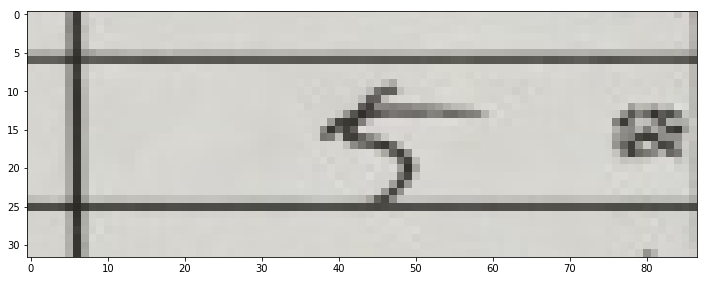

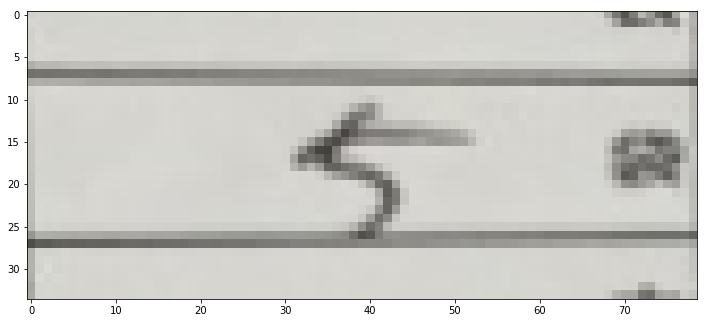

In [192]:
i = 72
plt.figure(figsize=(12, 12))

mask = masks[:, :, i]
box = boxes[i]
class_id = classes[i]
crop_img, warped = predict_mask(original_image, mask, box)
plt.imshow(crop_img)
plt.show()
plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

100
-----------
19
four_point_transform rect [[413. 430.]
 [490. 429.]
 [490. 463.]
 [413. 462.]]


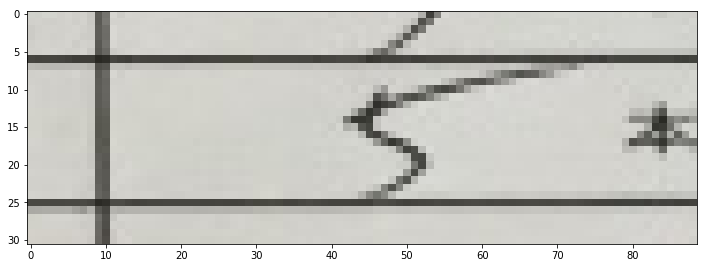

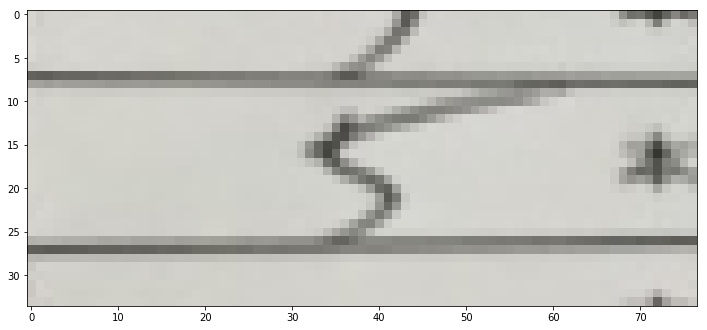

-----------
26
four_point_transform rect [[799. 219.]
 [875. 218.]
 [875. 252.]
 [800. 250.]]


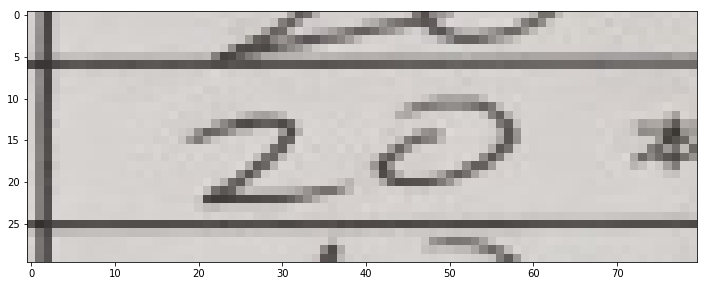

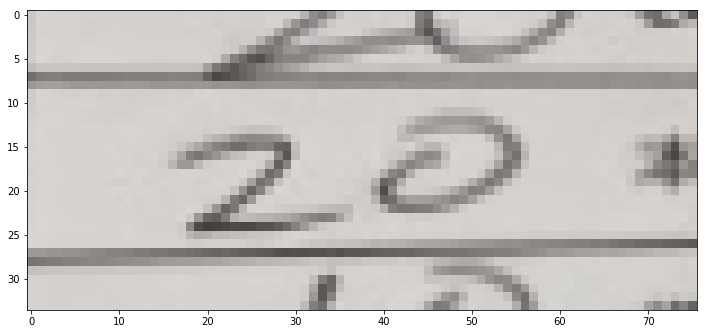

-----------
36
four_point_transform rect [[412. 797.]
 [488. 800.]
 [492. 830.]
 [412. 830.]]


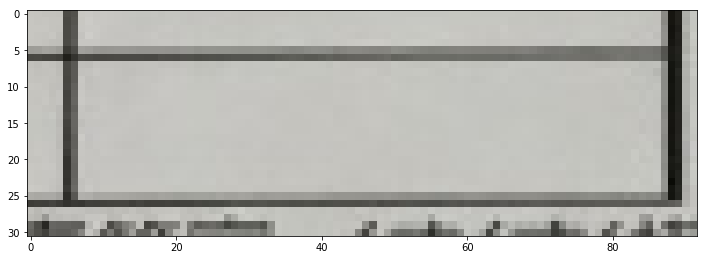

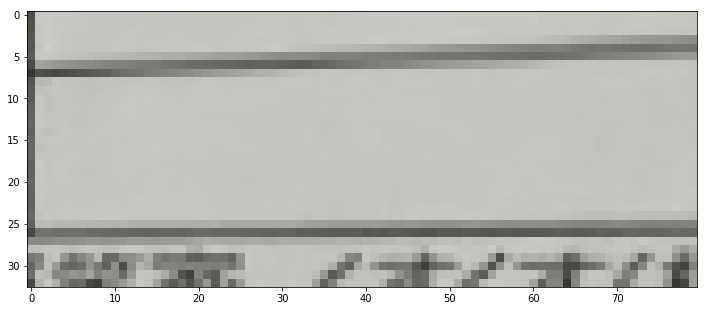

-----------
39
four_point_transform rect [[412. 411.]
 [489. 411.]
 [489. 444.]
 [413. 443.]]


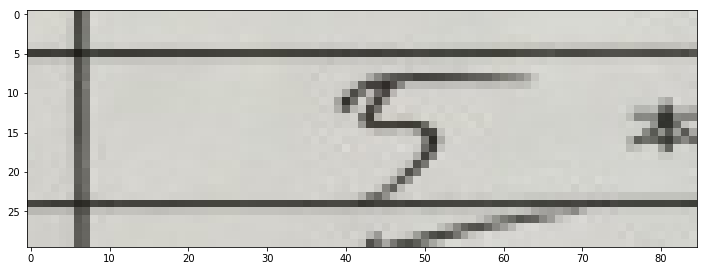

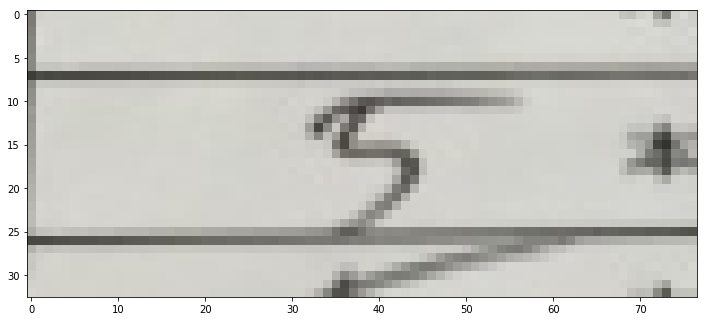

-----------
48
four_point_transform rect [[411. 219.]
 [491. 220.]
 [491. 252.]
 [412. 251.]]


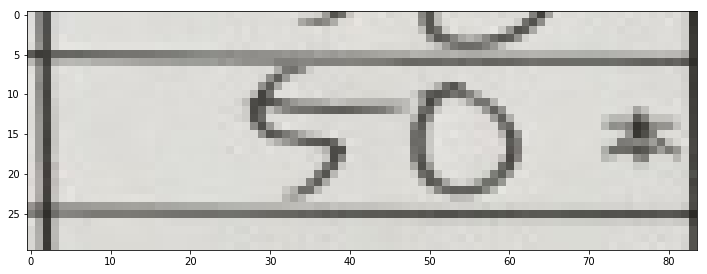

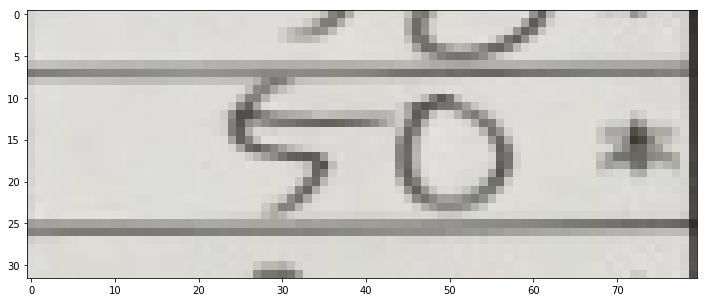

-----------
49
four_point_transform rect [[799. 409.]
 [879. 411.]
 [878. 442.]
 [799. 442.]]


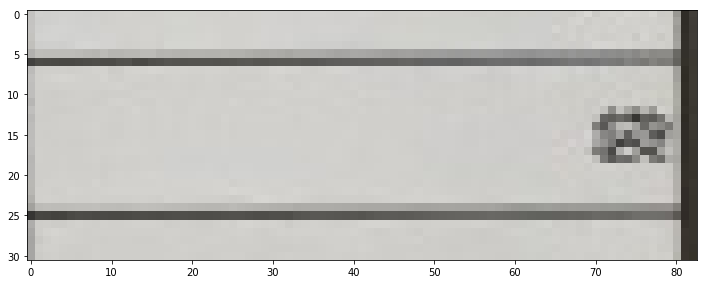

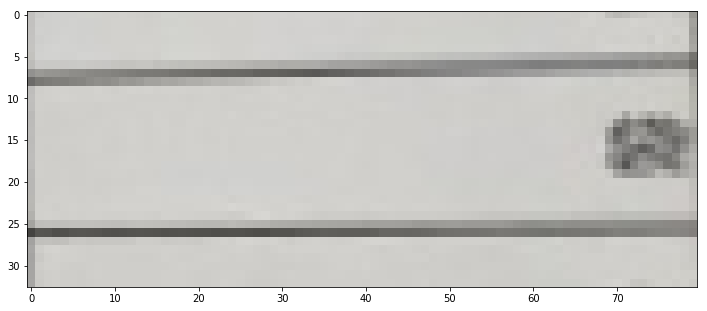

-----------
50
four_point_transform rect [[804. 639.]
 [882. 640.]
 [882. 673.]
 [804. 672.]]


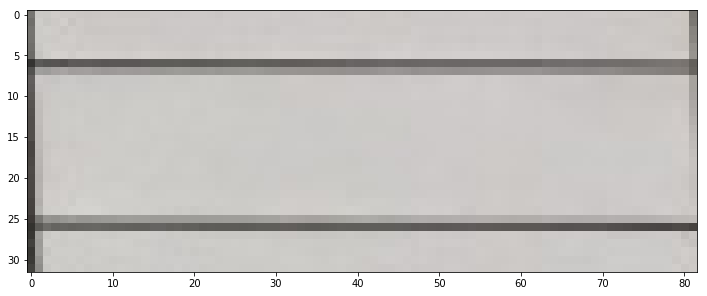

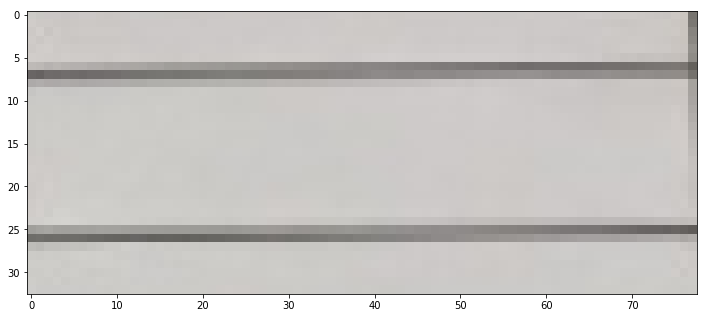

-----------
53
four_point_transform rect [[797. 353.]
 [876. 353.]
 [876. 386.]
 [798. 384.]]


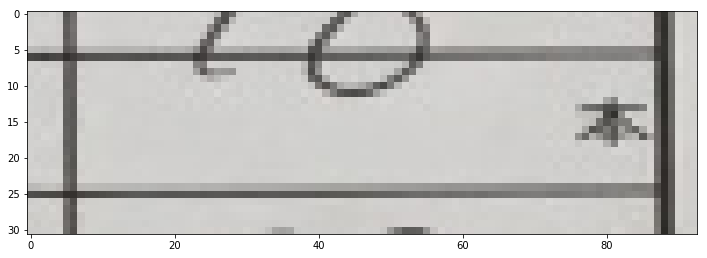

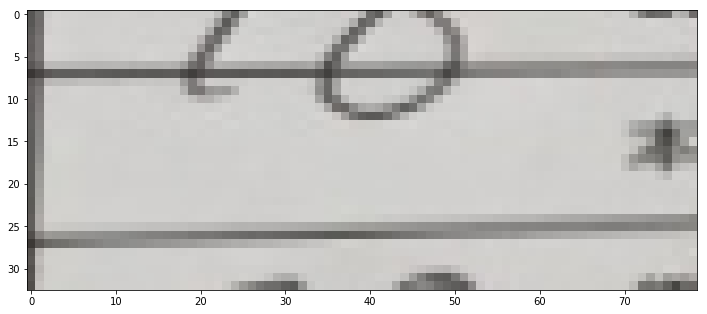

-----------
57
four_point_transform rect [[414. 507.]
 [491. 507.]
 [491. 540.]
 [414. 539.]]


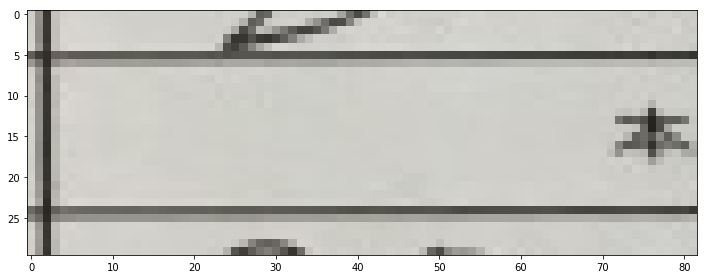

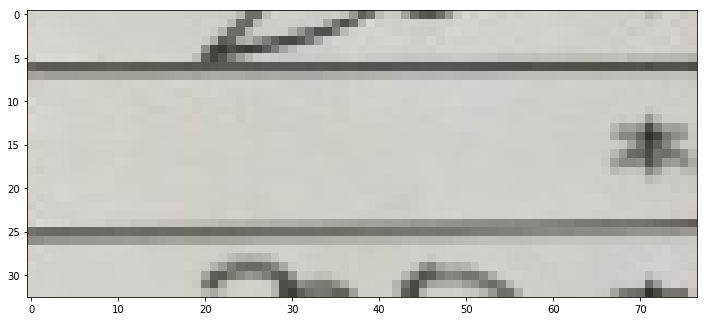

-----------
59
four_point_transform rect [[799. 334.]
 [878. 334.]
 [880. 366.]
 [799. 367.]]


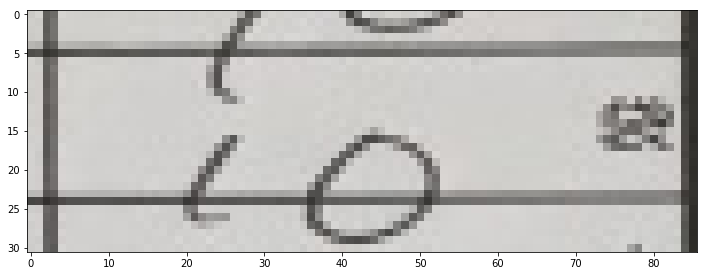

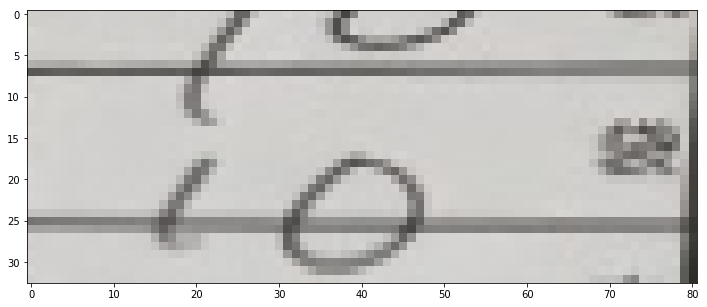

-----------
60
four_point_transform rect [[799. 467.]
 [880. 469.]
 [878. 499.]
 [799. 499.]]


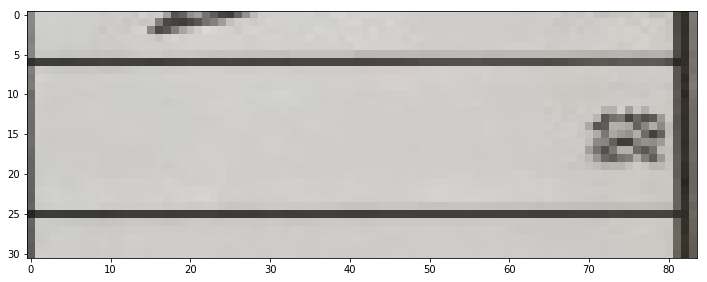

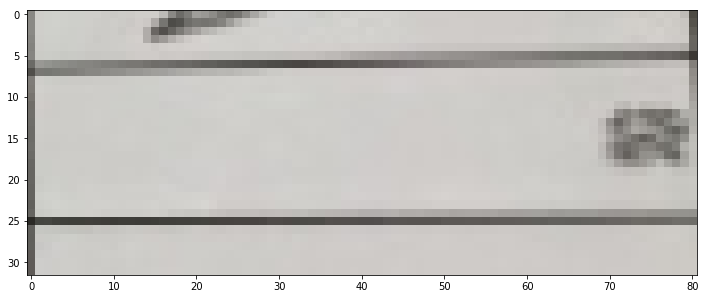

-----------
63
four_point_transform rect [[800. 296.]
 [880. 296.]
 [878. 328.]
 [799. 328.]]


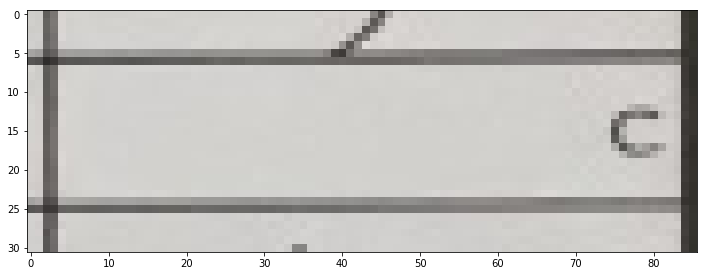

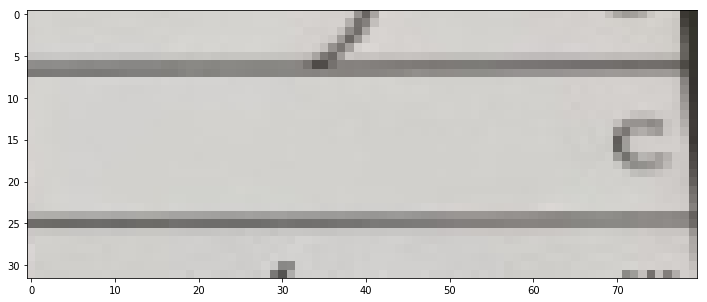

-----------
64
four_point_transform rect [[412. 449.]
 [490. 451.]
 [490. 480.]
 [413. 481.]]


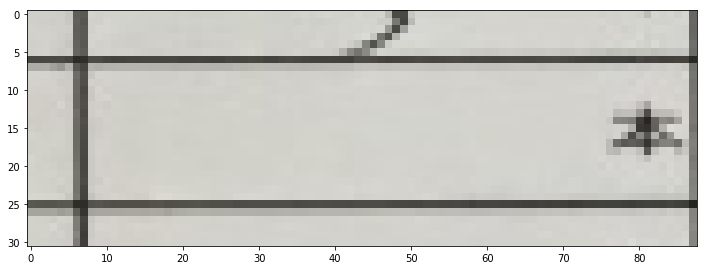

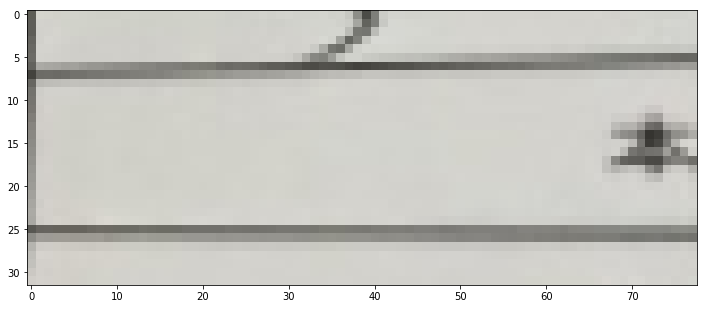

-----------
67
four_point_transform rect [[414. 316.]
 [491. 315.]
 [491. 349.]
 [414. 348.]]


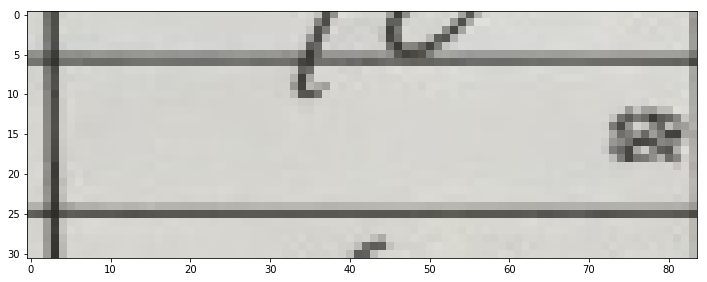

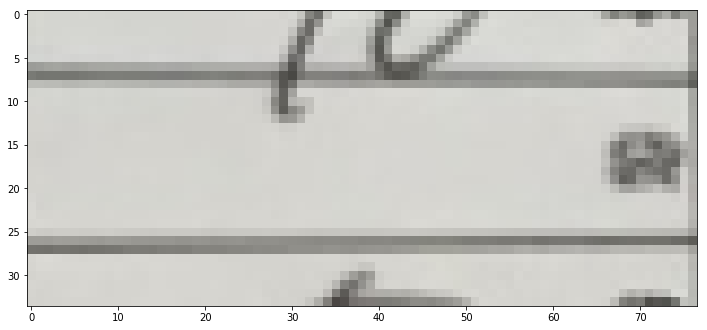

-----------
70
four_point_transform rect [[411. 239.]
 [491. 240.]
 [491. 271.]
 [411. 270.]]


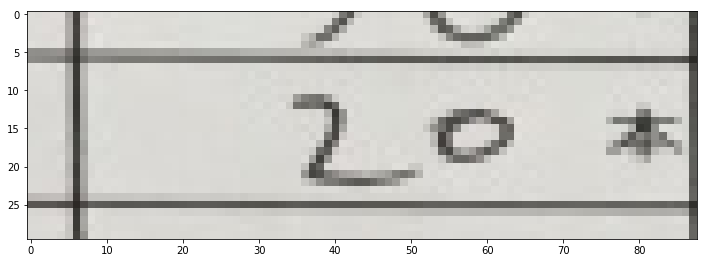

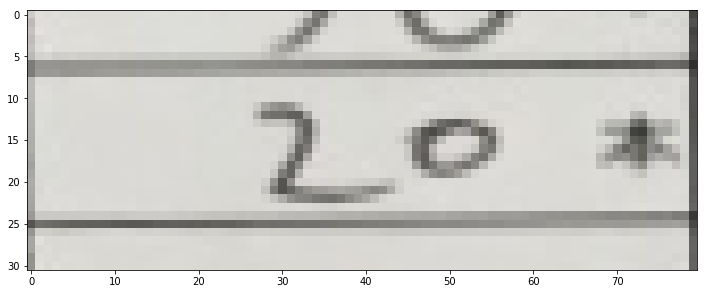

-----------
72
four_point_transform rect [[413. 335.]
 [491. 334.]
 [491. 368.]
 [412. 367.]]


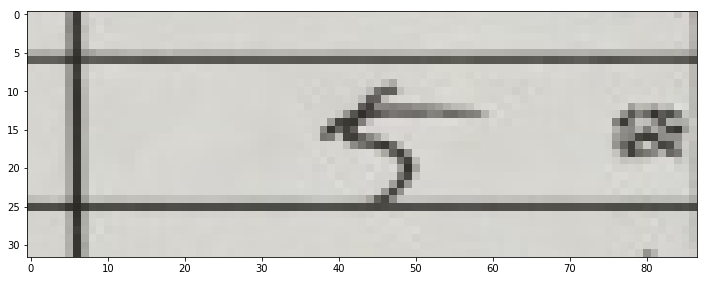

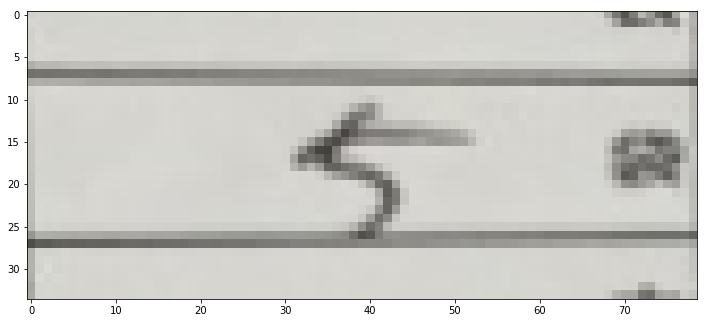

-----------
73
four_point_transform rect [[413. 758.]
 [473. 758.]
 [479. 789.]
 [412. 791.]]


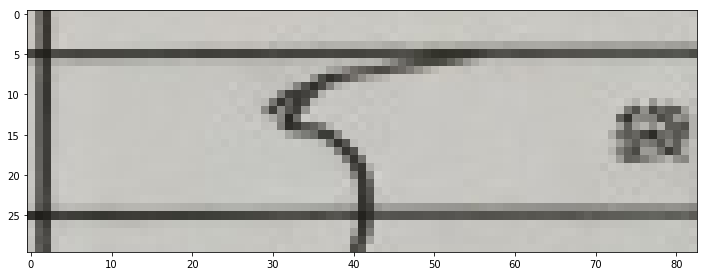

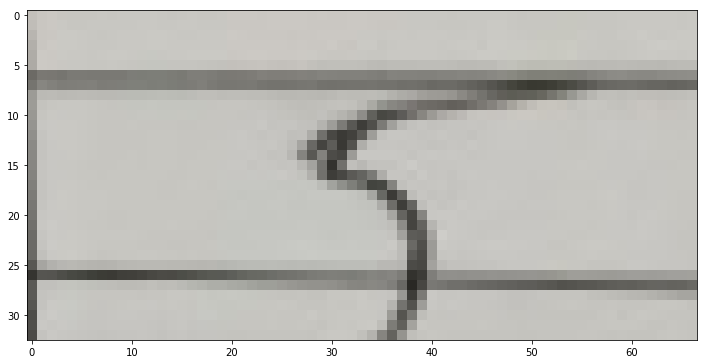

-----------
75
four_point_transform rect [[412. 545.]
 [492. 546.]
 [492. 577.]
 [412. 576.]]


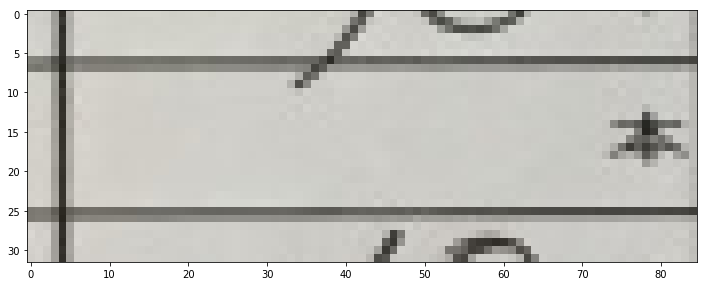

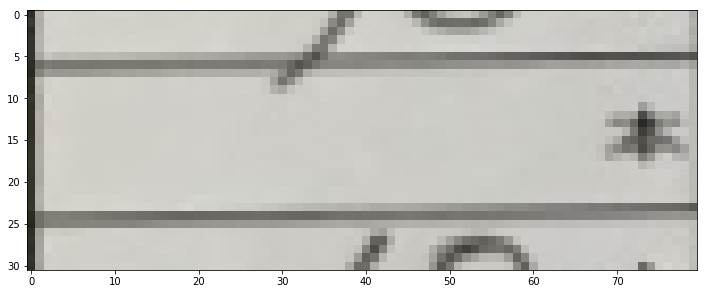

-----------
77
four_point_transform rect [[798. 429.]
 [879. 430.]
 [878. 461.]
 [801. 461.]]


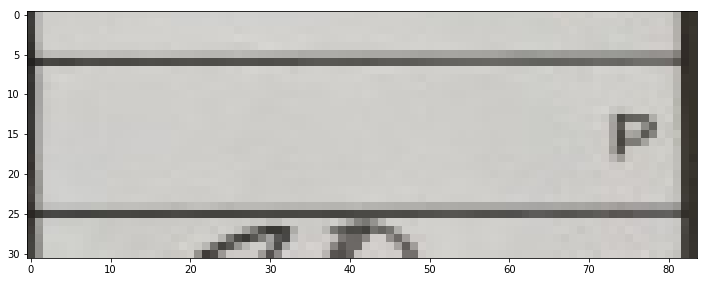

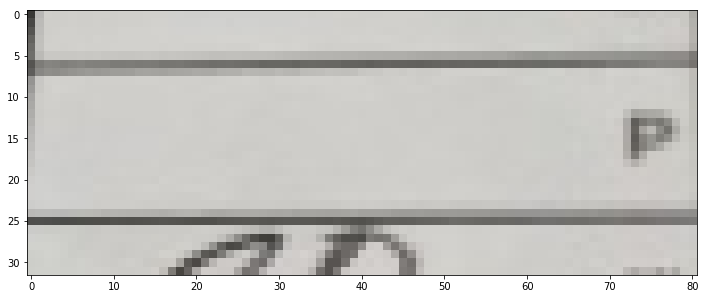

-----------
78
four_point_transform rect [[412. 468.]
 [490. 468.]
 [490. 501.]
 [412. 501.]]


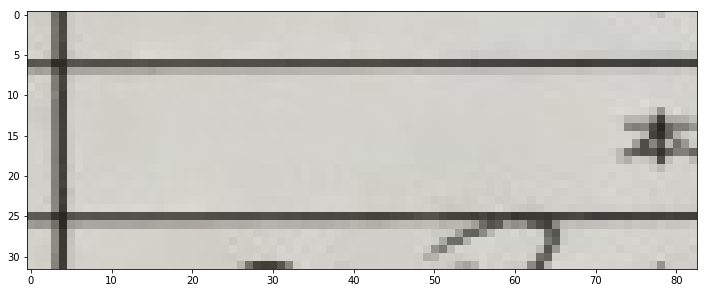

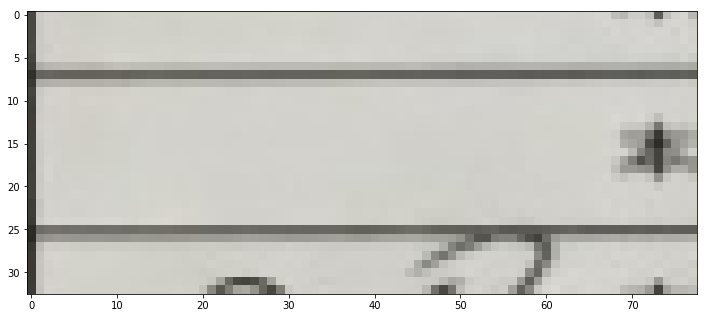

-----------
79
four_point_transform rect [[414. 526.]
 [490. 527.]
 [490. 558.]
 [413. 558.]]


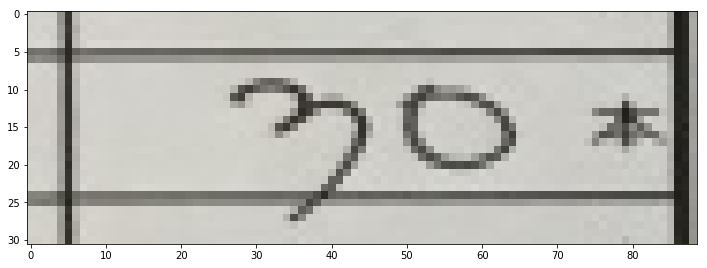

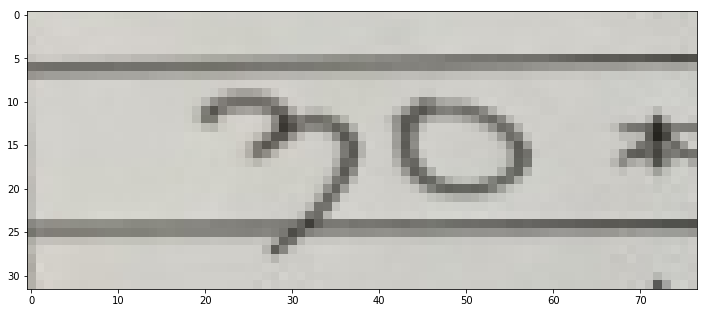

-----------
80
four_point_transform rect [[411. 296.]
 [488. 296.]
 [492. 329.]
 [411. 328.]]


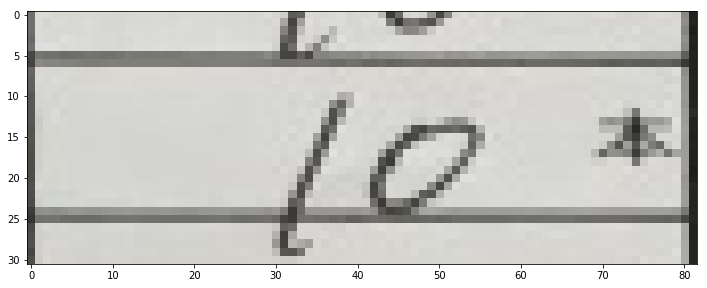

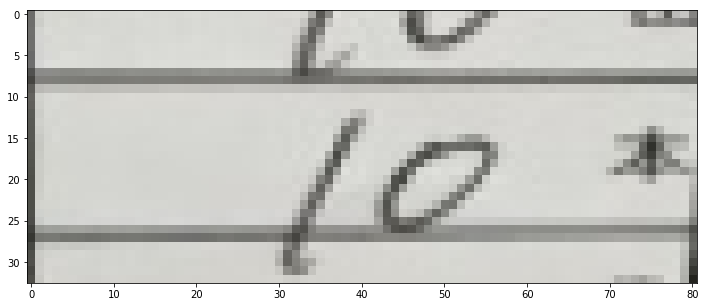

-----------
83
four_point_transform rect [[411. 354.]
 [489. 354.]
 [491. 386.]
 [411. 386.]]


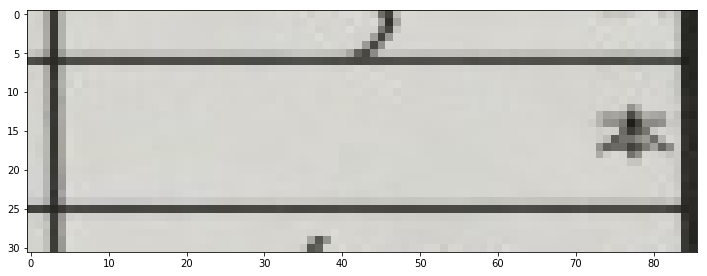

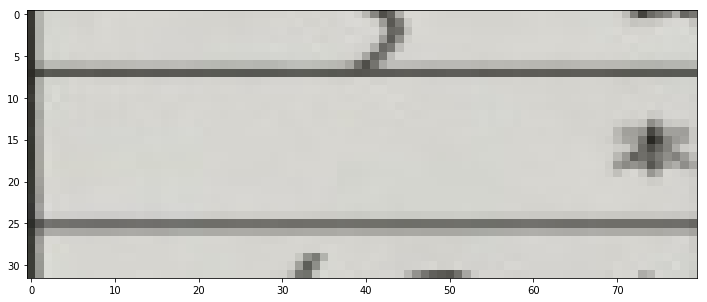

-----------
86
four_point_transform rect [[411. 602.]
 [490. 603.]
 [490. 635.]
 [412. 634.]]


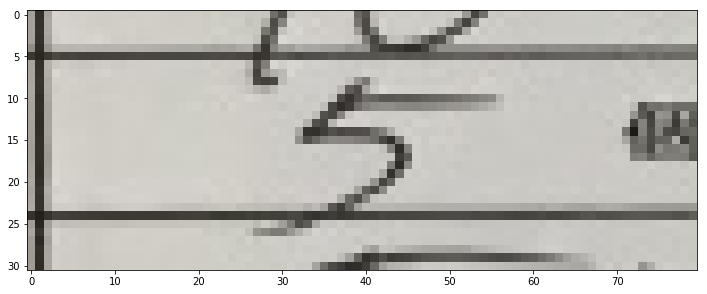

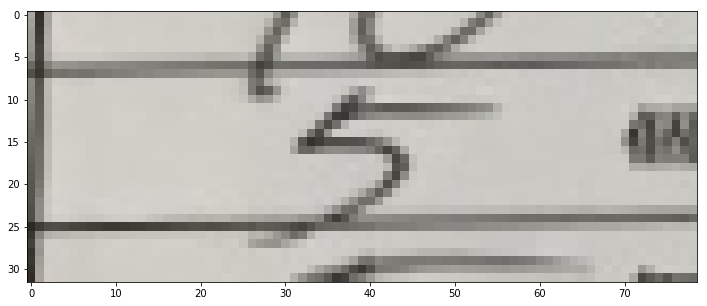

-----------
87
four_point_transform rect [[804. 620.]
 [882. 620.]
 [882. 653.]
 [804. 652.]]


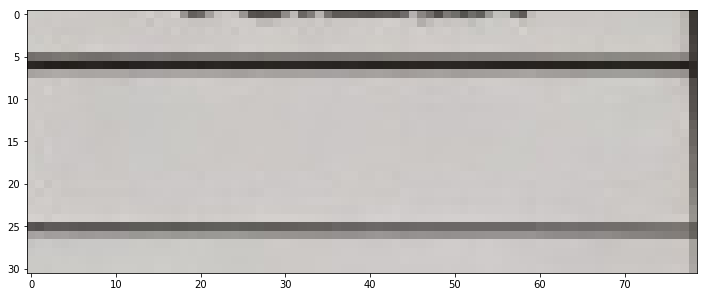

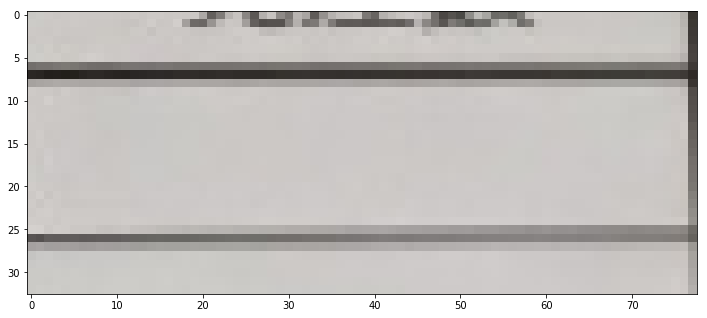

-----------
88
four_point_transform rect [[801. 314.]
 [876. 315.]
 [876. 348.]
 [801. 347.]]


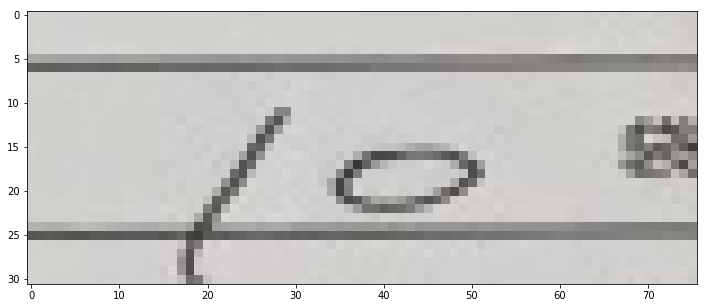

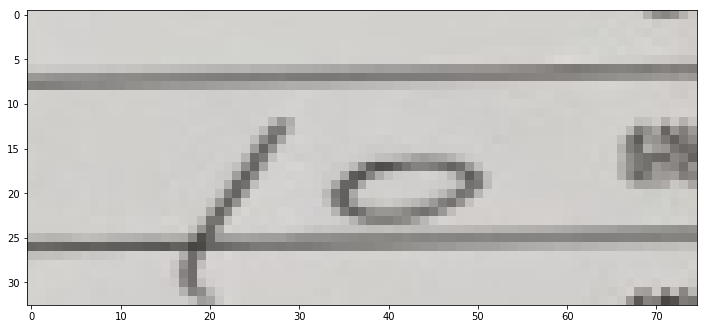

-----------
89
four_point_transform rect [[414. 622.]
 [490. 623.]
 [490. 653.]
 [414. 653.]]


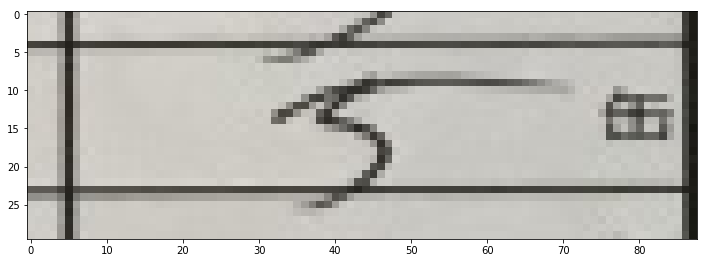

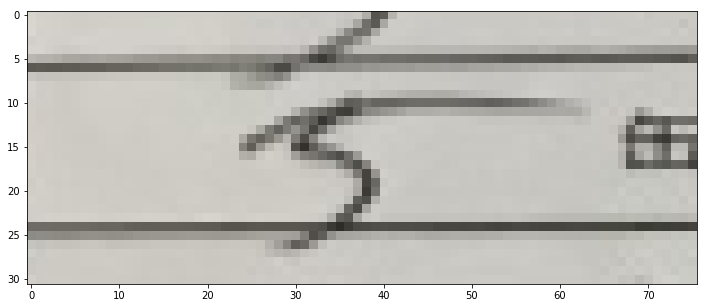

-----------
90
four_point_transform rect [[412. 487.]
 [491. 487.]
 [491. 520.]
 [412. 519.]]


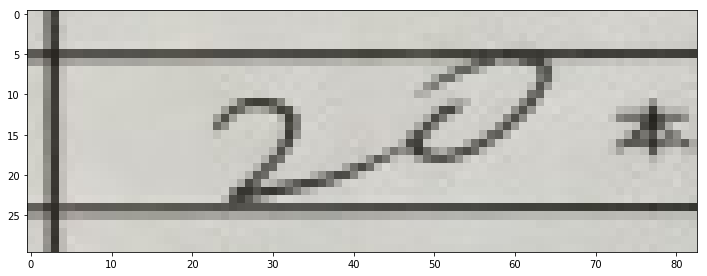

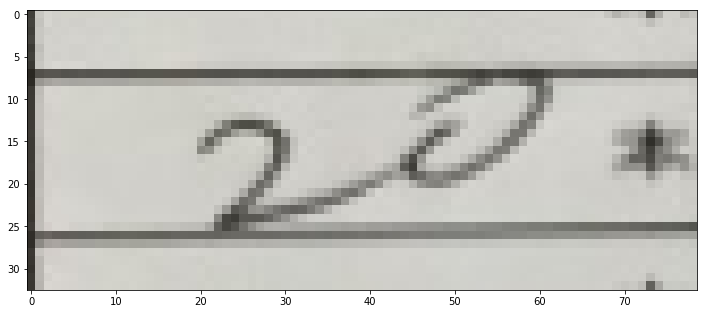

-----------
91
four_point_transform rect [[800. 276.]
 [879. 276.]
 [879. 309.]
 [800. 308.]]


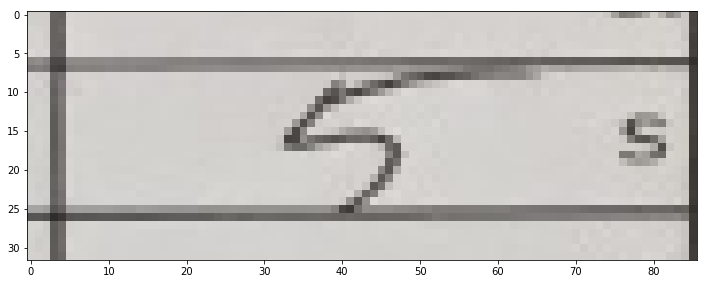

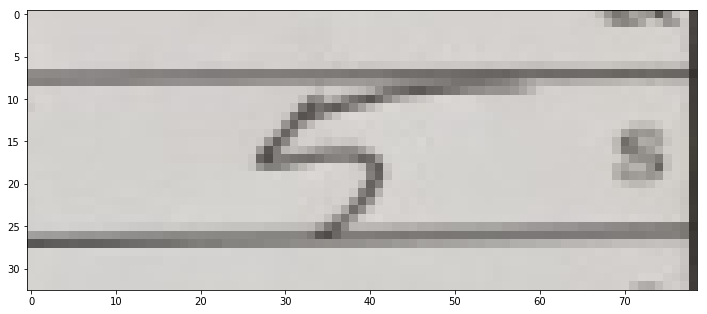

-----------
94
four_point_transform rect [[409. 257.]
 [490. 258.]
 [490. 292.]
 [412. 290.]]


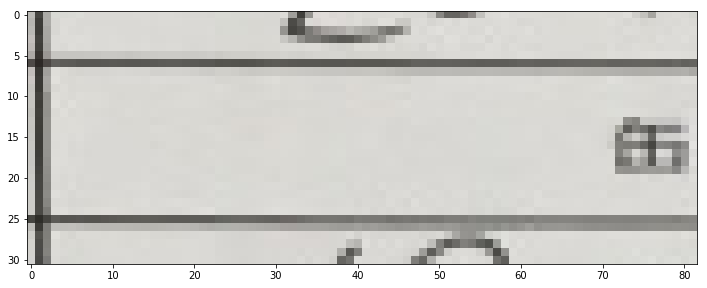

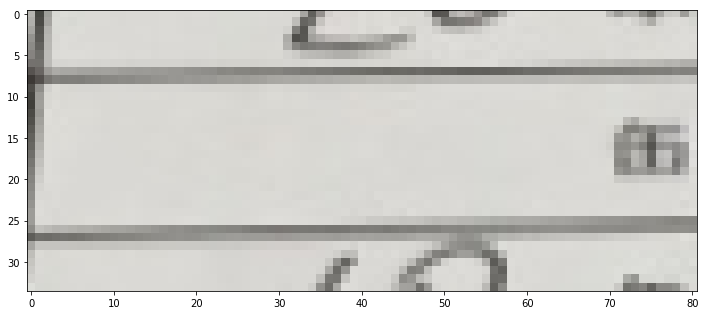

-----------
97
four_point_transform rect [[413. 738.]
 [487. 744.]
 [487. 767.]
 [412. 771.]]


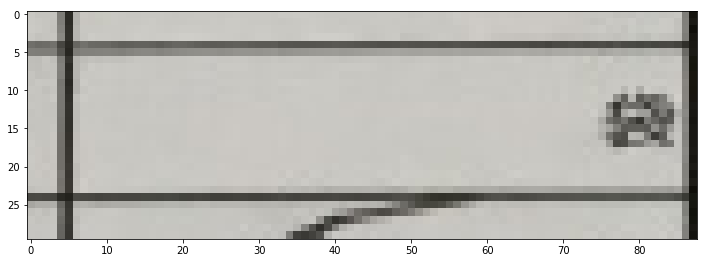

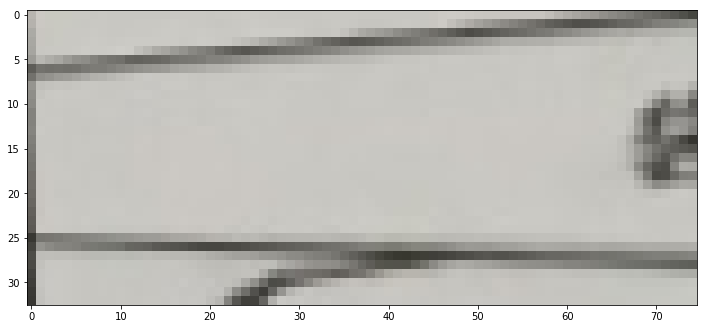

-----------
98
four_point_transform rect [[413. 640.]
 [490. 642.]
 [490. 673.]
 [414. 673.]]


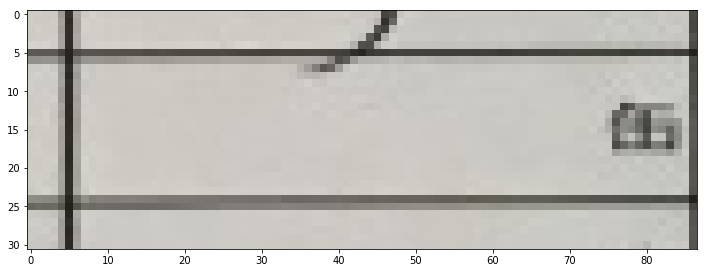

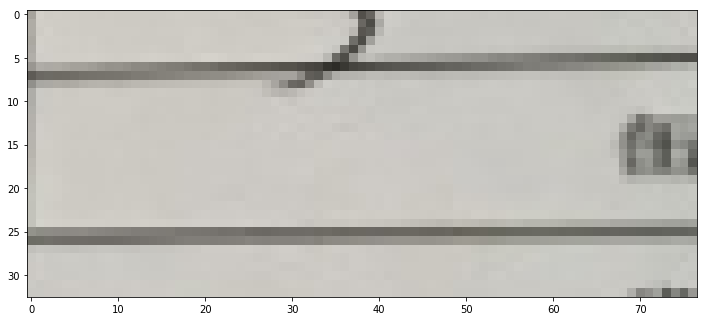

-----------
99
four_point_transform rect [[411. 563.]
 [489. 564.]
 [491. 595.]
 [411. 596.]]


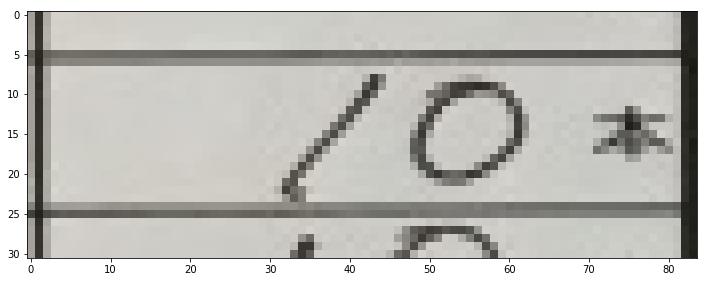

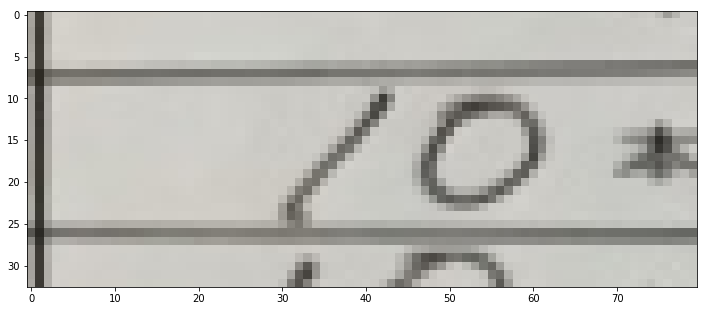

In [194]:
# i = 22
# import pytesseract

print(masks.shape[2])
count = 0

for i in range(masks.shape[2]):
    plt.figure(figsize=(12, 12))

    mask = masks[:, :, i]
    box = boxes[i]
    class_id = classes[i]
    if class_id == 2:
        print('-----------')
        print(i)
        crop_img, warped = predict_mask(original_image, mask, box)
#         print(crop_img)
#         print(warped)
        plt.imshow(crop_img)
        plt.show()
        plt.figure(figsize=(12, 12))
        plt.imshow(warped)
        plt.show()
#         text = pytesseract.image_to_string(warped, config='')
#         print("predict: %s" % text)
#         count = count + 1
#         if count > 10:
#             break

In [239]:
def predict_handwriting(original_image, mask, box):
    crop_img, warped = predict_mask(original_image, mask, box)
    print(warped.shape)
#     warped = warped[3:warped.shape[0]-3, 5:warped.shape[1]-15,:]
    warped = warped[:, 5:warped.shape[1]-15,:]

    # Read the input image 
    im = warped
    plt.imshow(warped)
    plt.show()
    
#     mask2 = warped.astype(np.uint8) * 255
#     equ = cv2.equalizeHist(mask2)
#     res = np.hstack((mask2,equ))
#     plt.imshow(res)
#     plt.show()

    # Convert to grayscale and apply Gaussian filtering
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(im_gray, (5, 5), 0)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

    gray_h = hsv[:, :, 0]
    gray_s = hsv[:, :, 1]
    gray_v = hsv[:, :, 2]

    thresh = threshold_otsu(gray_v)
    mask1 = gray_v < thresh

    print("mask1")
    plt.imshow(mask1)
    plt.show()

    mask1 = mask1.astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

    #apply blackhat and otsu thresholding
#     blackhat = cv2.morphologyEx(im_gray,cv2.MORPH_BLACKHAT,kernel)
#     _,thresh = cv2.threshold(blackhat,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
#     thresh = cv2.dilate(thresh,None)        #dilate thresholded image for better segmentation

#     print("thresh")
#     plt.imshow(thresh)
#     plt.show()
    #find external contours
#     (cnts,_) = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # Find contours in the image
    # ctrs, hier = cv2.findContours(im_th.copy(), cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_SIMPLE) #cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    _, contours, hierarchy = cv2.findContours(mask1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(contours)

    # Get rectangles contains each contour
    rects = [cv2.boundingRect(ctr) for ctr in contours]

    # For each rectangular region, calculate HOG features and predict
    # the digit using Linear SVM.
    for rect in rects:
        # Draw the rectangles
        cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 
        # Make the rectangular region around the digit
        leng = int(rect[3] * 1.5)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = mask1[pt1:pt1+leng, pt2:pt2+leng]
        print(roi.shape)
        if roi.shape[0] > 0 and roi.shape[1] > 0:
            # Resize the image
            roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
            roi = cv2.dilate(roi, (3, 3))
            # Calculate the HOG features
            roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
            nbr = clf.predict(np.array([roi_hog_fd], 'float64'))
            print('predicted: %s' % str(int(nbr[0])))
            cv2.putText(im, str(int(nbr[0])), (rect[0], rect[1]+7),cv2.FONT_HERSHEY_DUPLEX, 0.3, (0, 255, 255), 1)

    plt.imshow(im)
    plt.show

-----------
5
(5, 2)
[757 440 785 540]
(22, 99, 3)


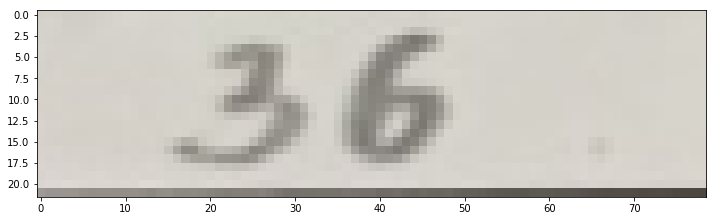

mask1


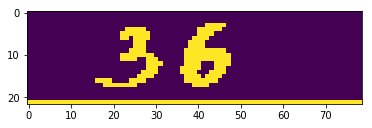

(1, 1)
predicted: 2
(21, 21)
predicted: 2
(0, 22)
-----------
6


/Users/vfa/anaconda3/envs/coreml/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(7, 2)
[485 444 509 540]
(20, 92, 3)


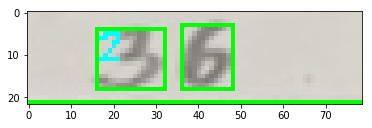

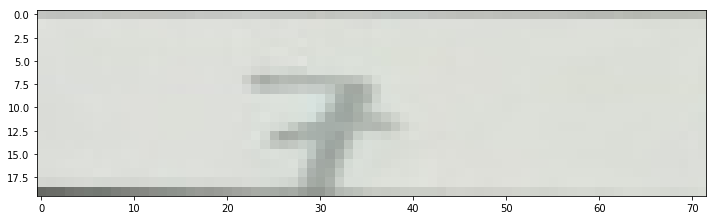

mask1


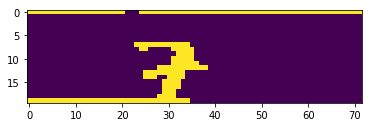

(16, 19)
predicted: 5
(1, 1)
predicted: 2
(1, 1)
predicted: 2
-----------
7
(4, 2)
[594 443 619 539]
(21, 95, 3)


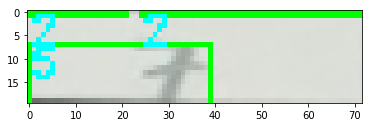

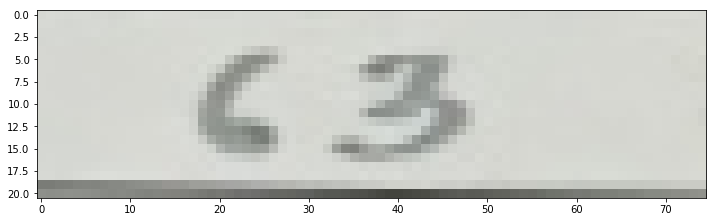

mask1


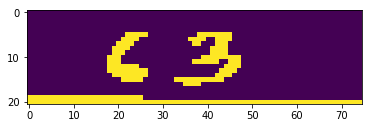

(2, 3)
predicted: 7
(18, 18)
predicted: 7
(16, 16)
predicted: 6
-----------
8
(5, 2)
[709 438 735 538]
(23, 95, 3)


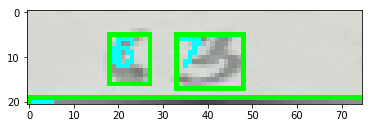

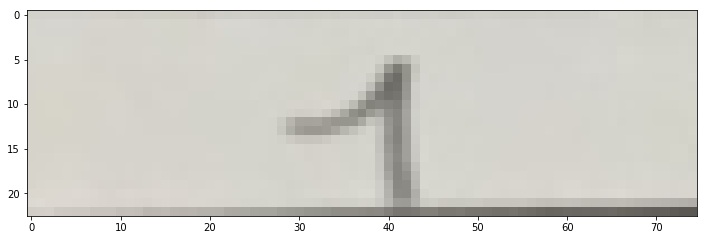

mask1


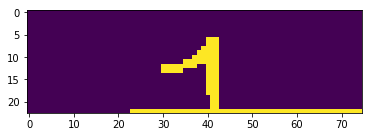

(21, 25)
predicted: 6
-----------
10
(4, 2)
[310 451 332 538]
(20, 82, 3)


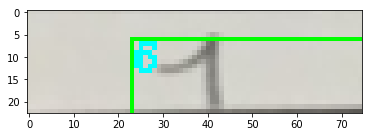

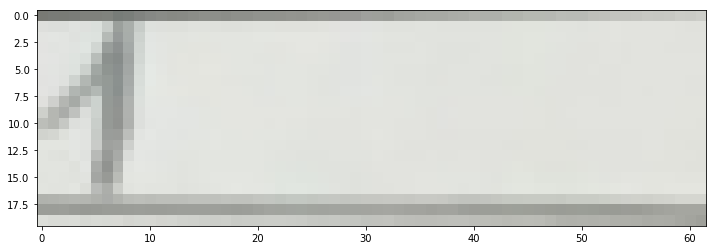

mask1


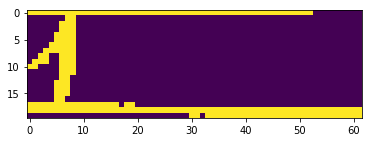

(5, 30)
predicted: 4
-----------
13
(5, 2)
[549 443 574 537]
(20, 93, 3)


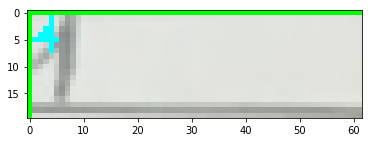

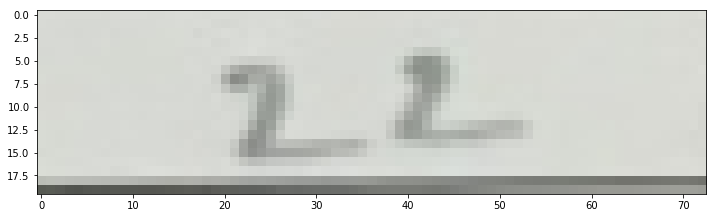

mask1


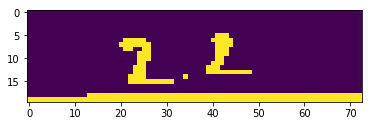

(2, 3)
predicted: 2
(1, 1)
predicted: 2
(15, 15)
predicted: 2
(13, 13)
predicted: 2
-----------
15
(9, 2)
[424 444 447 535]
(18, 90, 3)


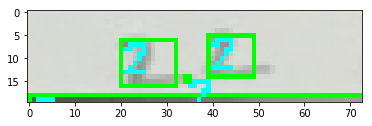

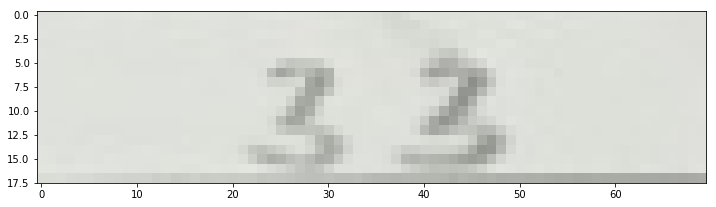

mask1


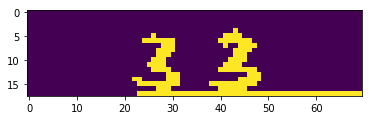

(17, 21)
predicted: 2
-----------
22
(6, 2)
[219 449 240 538]
(18, 84, 3)


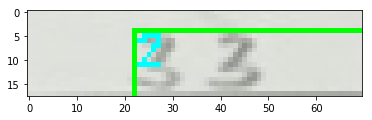

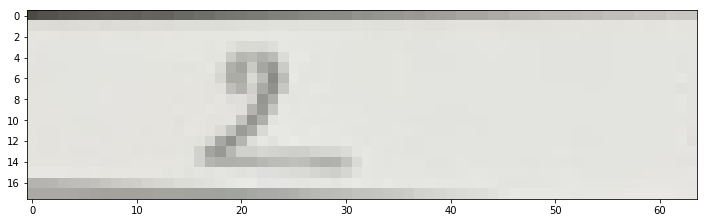

mask1


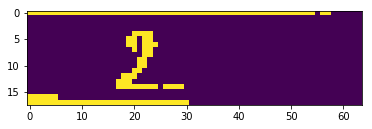

(2, 3)
predicted: 7
(1, 1)
predicted: 2
(16, 16)
predicted: 2
(1, 1)
predicted: 2
(1, 1)
predicted: 2
-----------
23
(4, 2)
[782 441 810 544]
(24, 98, 3)


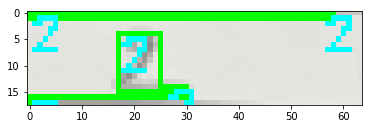

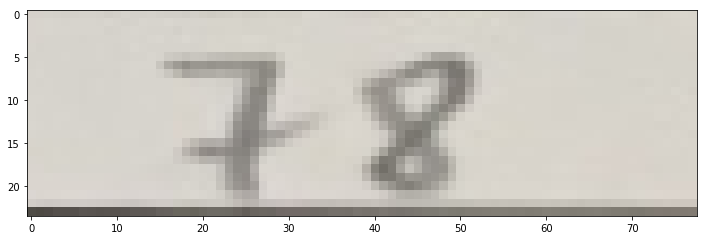

mask1


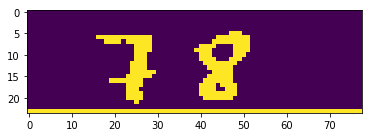

(1, 1)
predicted: 2
(22, 24)
predicted: 7
(23, 24)
predicted: 4
-----------
25
(4, 2)
[405 446 428 536]
(18, 89, 3)


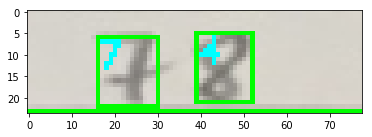

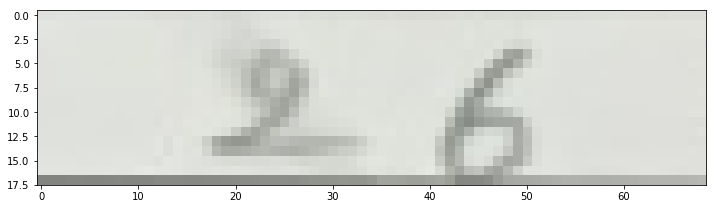

mask1


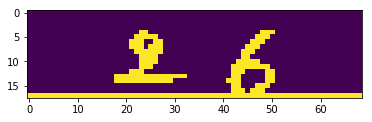

(17, 21)
predicted: 4
(16, 16)
predicted: 2
-----------
27
(4, 2)
[528 441 552 535]
(20, 90, 3)


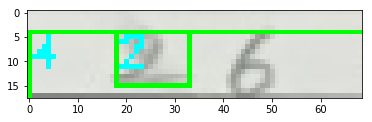

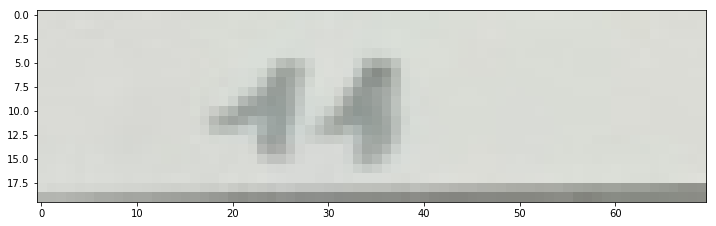

mask1


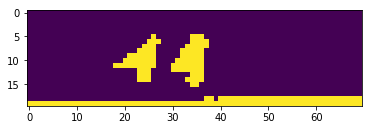

(2, 3)
predicted: 7
(16, 16)
predicted: 7
(15, 15)
predicted: 4
-----------
28
(6, 2)
[291 444 312 545]
(16, 88, 3)


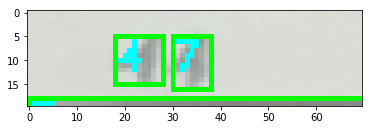

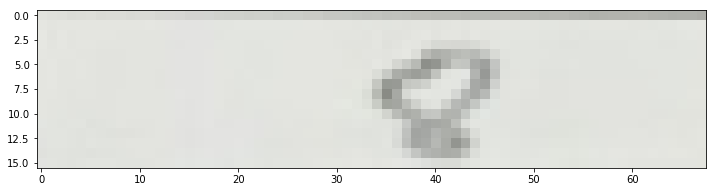

mask1


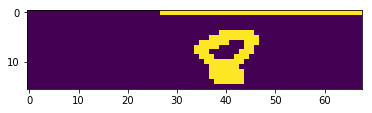

(15, 16)
predicted: 7
(1, 1)
predicted: 2
-----------
30
(7, 2)
[385 446 409 537]
(18, 88, 3)


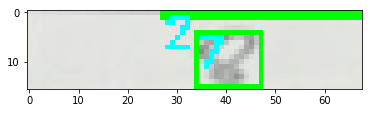

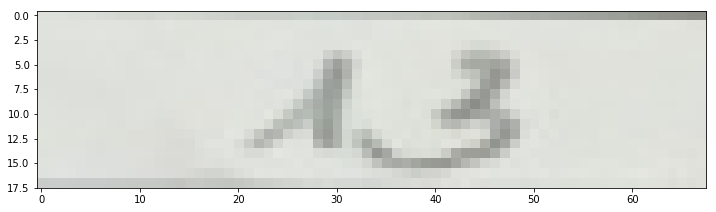

mask1


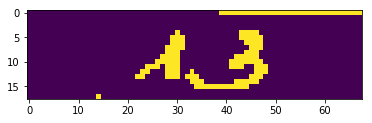

(1, 1)
predicted: 2
(17, 18)
predicted: 4
(15, 15)
predicted: 2
(1, 1)
predicted: 2
-----------
31
(4, 2)
[661 442 688 536]
(22, 93, 3)


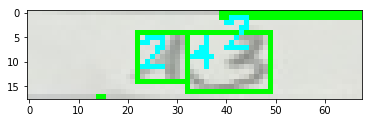

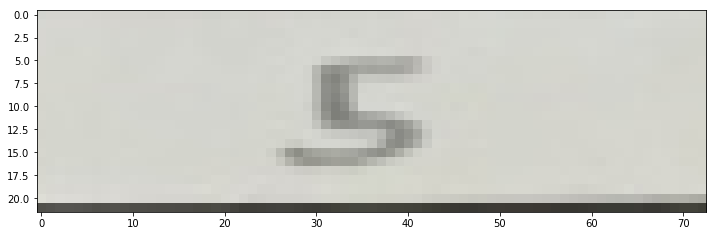

mask1


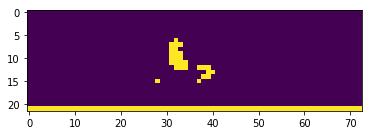

(1, 1)
predicted: 2
(1, 1)
predicted: 2
(6, 6)
predicted: 7
(10, 10)
predicted: 8
-----------
32
(4, 2)
[328 450 350 539]
(18, 84, 3)


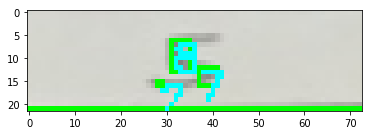

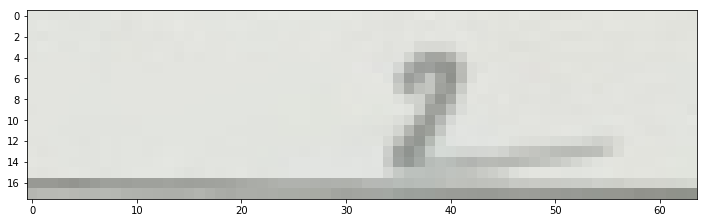

mask1


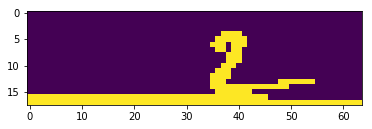

(17, 21)
predicted: 4
-----------
33
(5, 2)
[639 442 665 537]
(22, 94, 3)


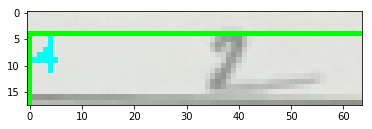

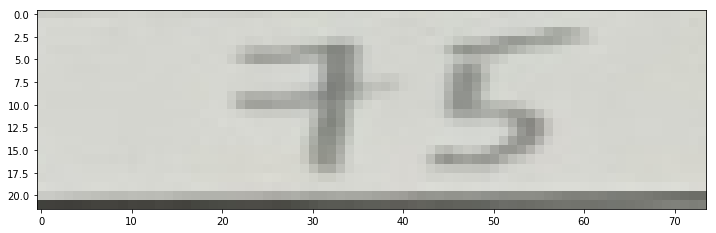

mask1


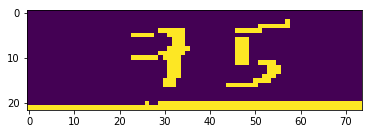

(2, 3)
predicted: 2
(9, 9)
predicted: 7
(9, 9)
predicted: 1
(1, 1)
predicted: 2
(19, 19)
predicted: 7
(4, 4)
predicted: 7
-----------
34
(4, 2)
[616 443 642 537]
(21, 93, 3)


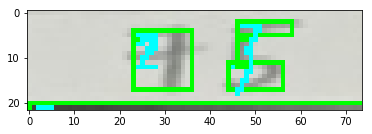

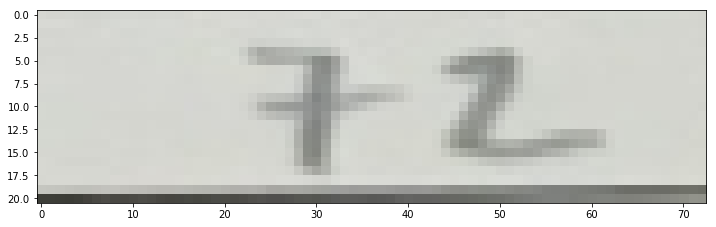

mask1


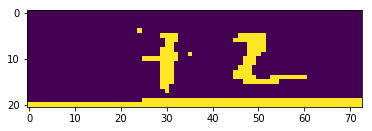

(2, 3)
predicted: 2
(1, 1)
predicted: 2
(16, 16)
predicted: 2
(19, 19)
predicted: 4
(1, 1)
predicted: 2
-----------
40
(6, 2)
[684 443 713 538]
(23, 94, 3)


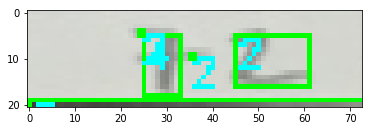

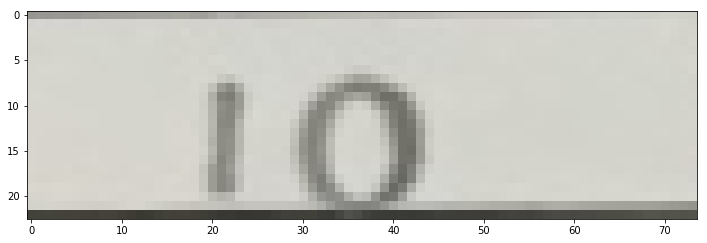

mask1


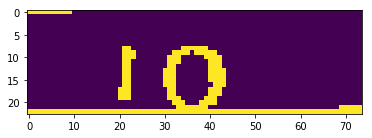

(19, 22)
predicted: 0
(18, 18)
predicted: 4
(1, 1)
predicted: 2
-----------
43
(5, 2)
[386 874 407 966]
(18, 91, 3)


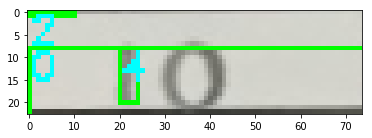

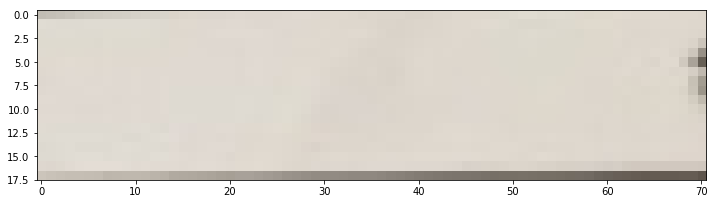

mask1


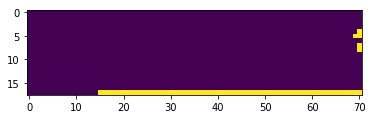

(1, 1)
predicted: 2
(3, 2)
predicted: 1
(3, 2)
predicted: 4
-----------
45
(7, 2)
[731 439 761 539]
(22, 95, 3)


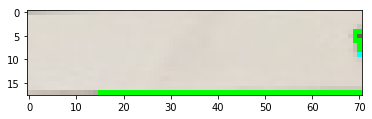

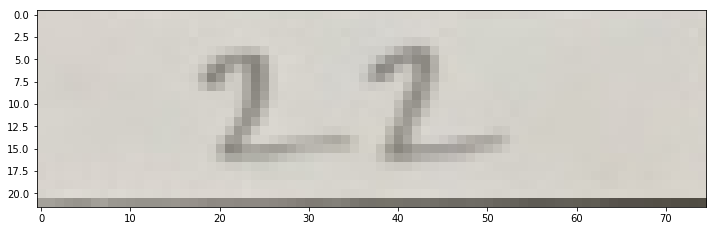

mask1


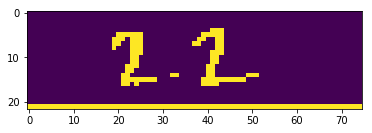

(1, 1)
predicted: 2
(1, 1)
predicted: 2
(18, 18)
predicted: 2
(19, 19)
predicted: 2
-----------
48
(6, 2)
[464 441 489 535]
(19, 90, 3)


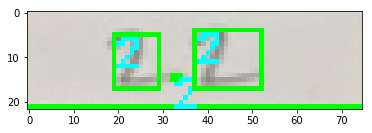

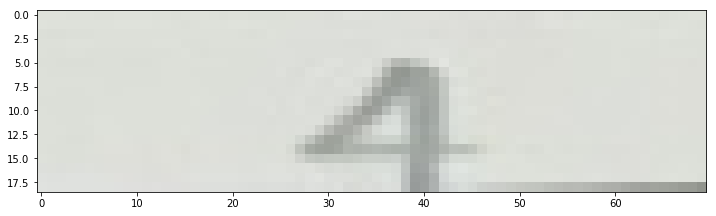

mask1


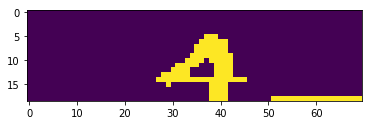

(1, 1)
predicted: 2
(17, 21)
predicted: 9
-----------
50
(9, 2)
[507 443 532 538]
(20, 94, 3)


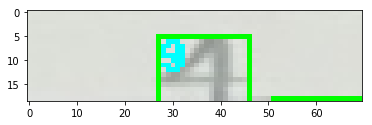

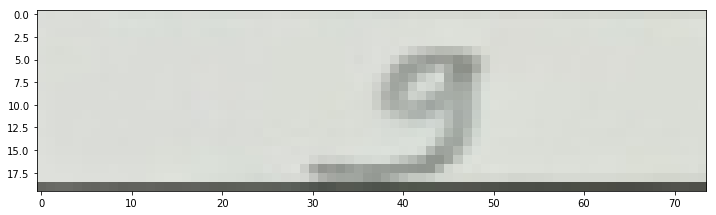

mask1


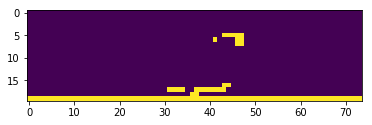

(1, 1)
predicted: 2
(5, 6)
predicted: 7
(1, 1)
predicted: 2
(4, 4)
predicted: 7
-----------
52
(4, 2)
[407 878 426 965]
(18, 86, 3)


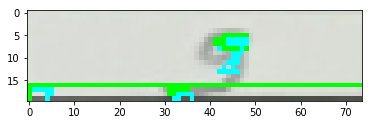

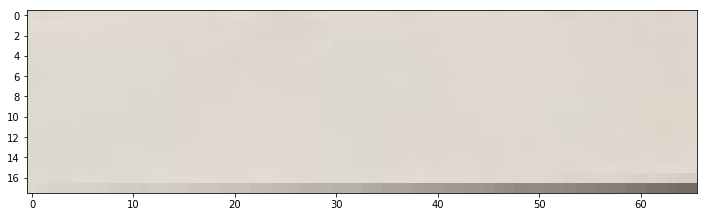

mask1


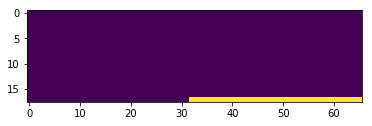

(1, 1)
predicted: 2
-----------
54
(6, 2)
[311 863 330 955]
(17, 88, 3)


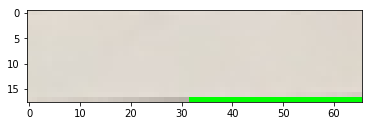

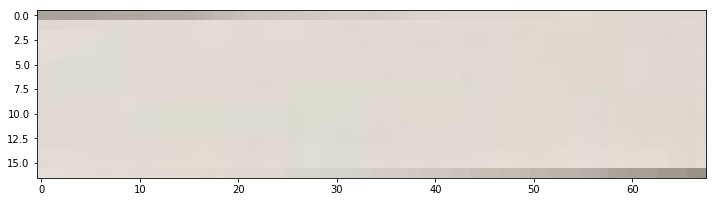

mask1


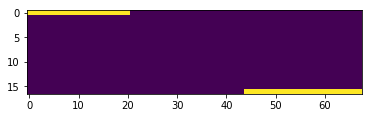

(1, 1)
predicted: 2
(1, 1)
predicted: 2
-----------
57
(5, 2)
[329 868 350 958]
(18, 89, 3)


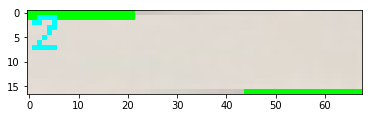

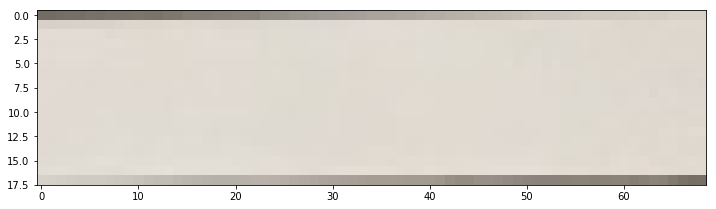

mask1


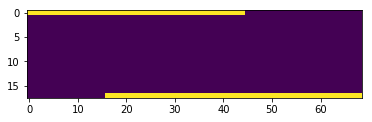

(1, 1)
predicted: 2
(1, 1)
predicted: 2
-----------
58
(5, 2)
[348 871 369 960]
(17, 88, 3)


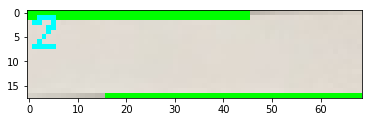

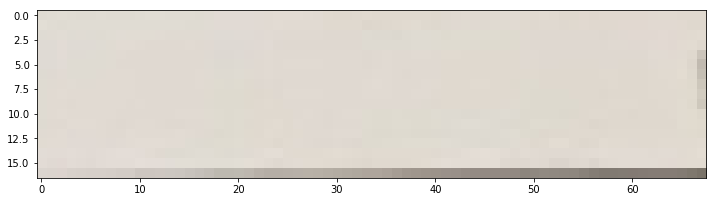

mask1


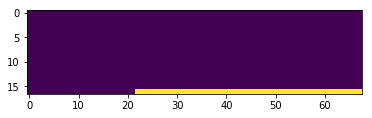

(1, 1)
predicted: 2
-----------
60
(4, 2)
[445 445 468 536]
(19, 90, 3)


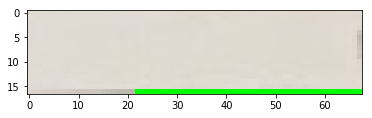

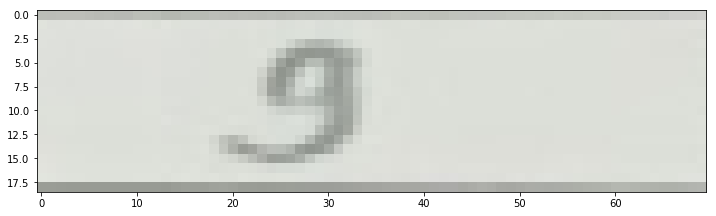

mask1


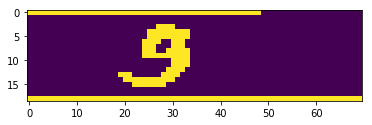

(1, 1)
predicted: 2
(19, 19)
predicted: 7
(1, 1)
predicted: 2
-----------
61
(5, 2)
[274 451 295 540]
(18, 82, 3)


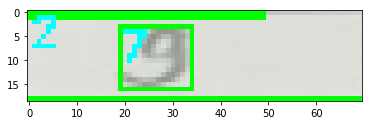

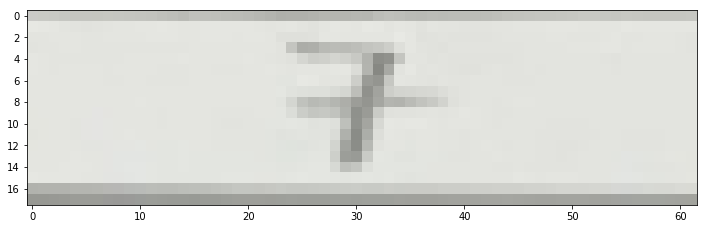

mask1


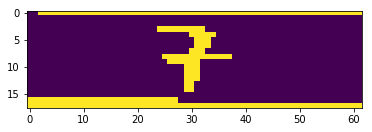

(2, 3)
predicted: 7
(18, 18)
predicted: 7
(1, 1)
predicted: 2
-----------
62
(6, 2)
[466 882 488 979]
(18, 92, 3)


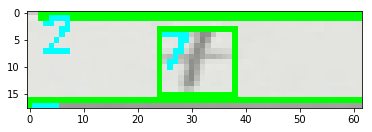

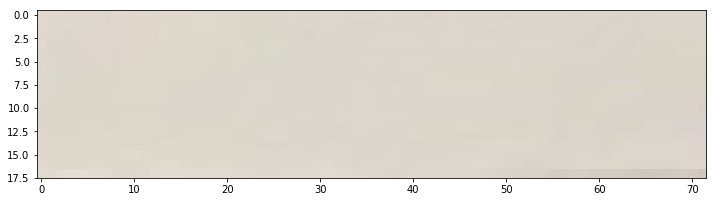

mask1


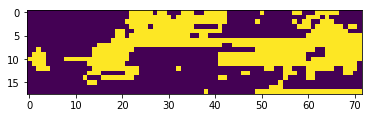

(1, 1)
predicted: 2
(1, 1)
predicted: 2
(1, 1)
predicted: 2
(1, 1)
predicted: 2
(7, 0)
(1, 1)
predicted: 2
(1, 1)
predicted: 2
(1, 1)
predicted: 2
(4, 27)
predicted: 1
-----------
63
(4, 2)
[348 448 370 536]
(17, 87, 3)


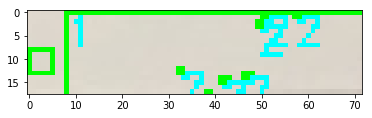

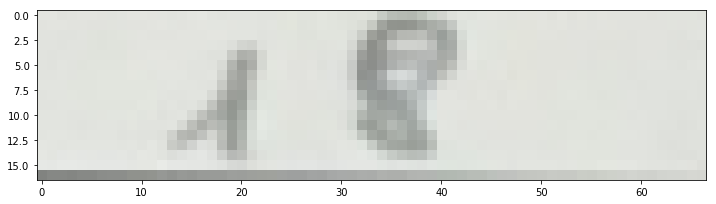

mask1


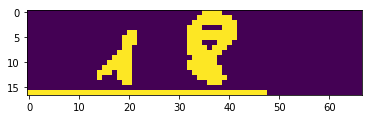

(1, 1)
predicted: 2
(16, 16)
predicted: 4
(4, 22)
predicted: 4
-----------
69
(6, 2)
[291 863 312 953]
(16, 89, 3)


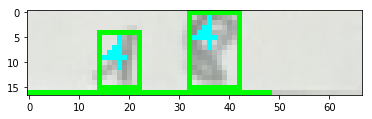

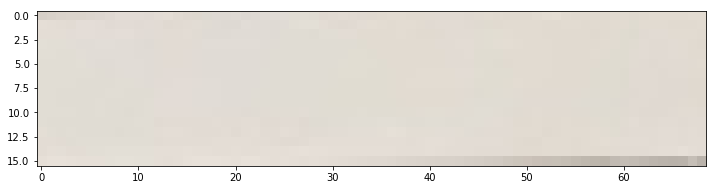

mask1


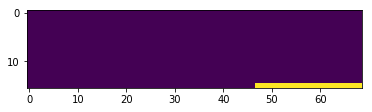

(1, 1)
predicted: 2
-----------
70
(8, 2)
[807 431 835 548]
(22, 102, 3)


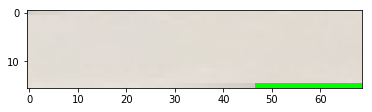

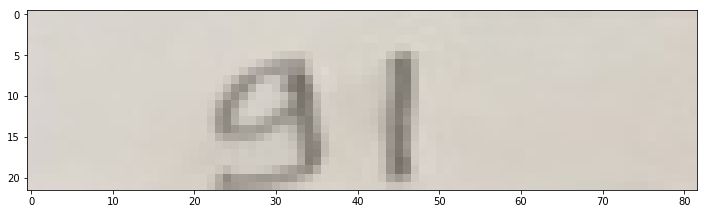

mask1


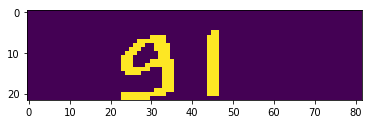

(20, 24)
predicted: 0
(21, 24)
predicted: 1
-----------
71
(6, 2)
[220 853 240 942]
(16, 85, 3)


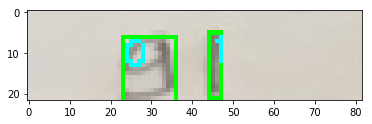

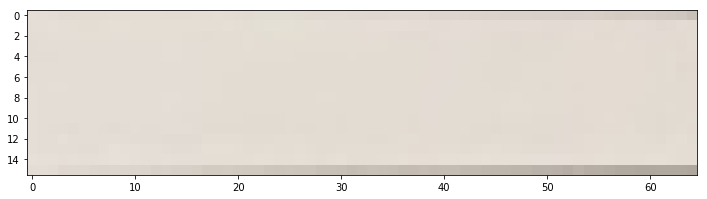

mask1


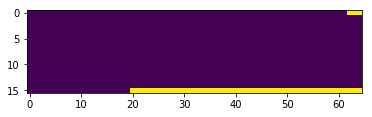

(1, 1)
predicted: 2
(1, 1)
predicted: 2
-----------
72
(6, 2)
[426 876 446 972]
(18, 91, 3)


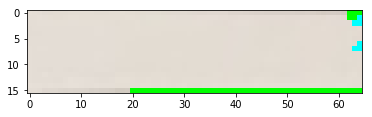

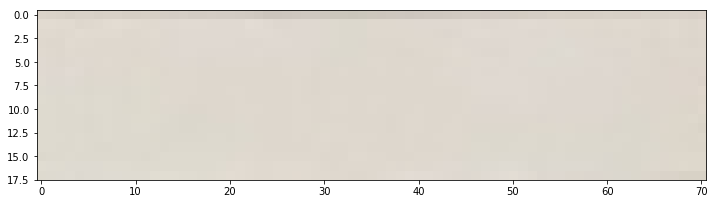

mask1


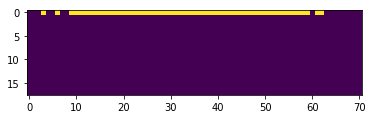

(1, 1)
predicted: 2
(1, 1)
predicted: 2
(1, 1)
predicted: 2
(1, 1)
predicted: 2


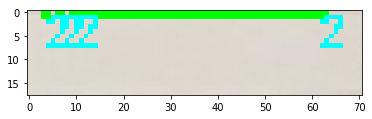

In [241]:
# Import the modules
import cv2
from sklearn.externals import joblib
from skimage.feature import hog
from skimage.filters import threshold_otsu
import numpy as np

# Load the classifier
clf = joblib.load("digits_cls.pkl")

for i in range(masks.shape[2]):
    plt.figure(figsize=(12, 12))

    mask = masks[:, :, i]
    box = boxes[i]
    class_id = classes[i]
    if class_id == 2:
        print('-----------')
        print(i)
        predict_handwriting(original_image, mask, box)
#         break
        
# cv2.waitKey()

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
## Extract object